# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

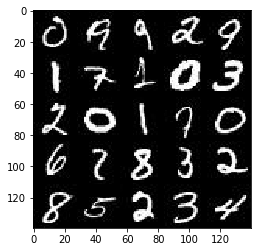

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

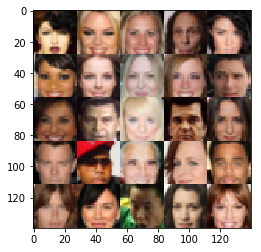

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(shape=[None,image_width,image_height,image_channels],dtype=tf.float32,name='input_real')
    inputs_z=tf.placeholder(shape=[None,z_dim],dtype=tf.float32,name='input_z')
    learning_rate=tf.placeholder(dtype=tf.float32,name='lr',shape=())
    return inputs_real,inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        #conv1
        x1=tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1=tf.maximum(x1,0.2*x1)
        x1=tf.nn.dropout(x1,0.8)
        #14*14*64
        
        #conv2
        x2=tf.layers.conv2d(x1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2=tf.layers.batch_normalization(x2,training=True)
        x2=tf.maximum(x2,0.2*x2)
        x2=tf.nn.dropout(x2,0.8)
        #7*7*128
        
        #conv3
        x3=tf.layers.conv2d(x2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())#4*4*256
        logits=tf.layers.dense(tf.reshape(x3,(-1,4*4*256)),1) #fully-connected
        output=tf.nn.sigmoid(logits)
        
    return  output,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse=not is_train
    with tf.variable_scope('generator',reuse=reuse):
        
        x1=tf.layers.dense(z,(7*7*512))
        x1=tf.reshape(x1,(-1,7,7,512))
        x1=tf.layers.batch_normalization(x1,training=is_train)
        x1=tf.maximum(x1,0.2*x1)
        x1=tf.nn.dropout(x1,0.8)
        #7*7*512
        
        #conv1
        x2=tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2=tf.layers.batch_normalization(x2,training=is_train)
        x2=tf.maximum(x2,0.2*x2)
        x2=tf.nn.dropout(x2,0.8)
        #14*14*256
        
        
        #conv2
        logits=tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=2,padding='same')
        output=0.5*tf.tanh(logits)
        #28*28*out_channel_dim
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model=generator(input_z,out_channel_dim)
    d_real_output,d_real_logits=discriminator(input_real)
    d_fake_output,d_fake_logits=discriminator(g_model,True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_output)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_output)))
    d_loss=d_loss_real+d_loss_fake
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_output)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars=tf.trainable_variables()
    d_vars=[var for var in t_vars if var.name.startswith('discriminator')]
    g_vars=[var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    inputs_real,inputs_z,lr=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss=model_loss(inputs_real, inputs_z,data_shape[3])
    d_opt,g_opt=model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                 # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,inputs_z: batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d,train_loss_g = d_loss.eval({inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate}) ,g_loss.eval({inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                    print("Epoch {}/{}...".format(steps, epoch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, batch_size, inputs_z, data_shape[3], data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 10/0... Discriminator Loss: 2.1720... Generator Loss: 0.5084
Epoch 20/0... Discriminator Loss: 3.0955... Generator Loss: 0.2947
Epoch 30/0... Discriminator Loss: 2.9771... Generator Loss: 0.7229
Epoch 40/0... Discriminator Loss: 2.2682... Generator Loss: 0.3873
Epoch 50/0... Discriminator Loss: 1.7992... Generator Loss: 1.0043
Epoch 60/0... Discriminator Loss: 2.5288... Generator Loss: 0.1804
Epoch 70/0... Discriminator Loss: 2.1633... Generator Loss: 0.2718
Epoch 80/0... Discriminator Loss: 2.1177... Generator Loss: 0.3753
Epoch 90/0... Discriminator Loss: 1.8990... Generator Loss: 0.5562
Epoch 100/0... Discriminator Loss: 2.0909... Generator Loss: 0.3388


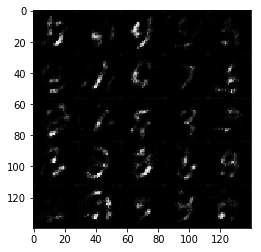

Epoch 110/0... Discriminator Loss: 1.6932... Generator Loss: 0.5735
Epoch 120/0... Discriminator Loss: 2.1795... Generator Loss: 0.4332
Epoch 130/0... Discriminator Loss: 2.0984... Generator Loss: 0.4402
Epoch 140/0... Discriminator Loss: 1.7073... Generator Loss: 0.4599
Epoch 150/0... Discriminator Loss: 1.7510... Generator Loss: 0.5548
Epoch 160/0... Discriminator Loss: 1.6078... Generator Loss: 0.5291
Epoch 170/0... Discriminator Loss: 1.9696... Generator Loss: 0.4853
Epoch 180/0... Discriminator Loss: 1.5880... Generator Loss: 0.4805
Epoch 190/0... Discriminator Loss: 1.6929... Generator Loss: 0.5547
Epoch 200/0... Discriminator Loss: 1.4862... Generator Loss: 0.8119


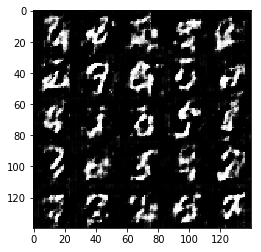

Epoch 210/0... Discriminator Loss: 1.6000... Generator Loss: 0.5199
Epoch 220/0... Discriminator Loss: 1.7846... Generator Loss: 0.3882
Epoch 230/0... Discriminator Loss: 1.6909... Generator Loss: 0.4213
Epoch 240/0... Discriminator Loss: 1.5818... Generator Loss: 0.5423
Epoch 250/0... Discriminator Loss: 1.4833... Generator Loss: 0.7348
Epoch 260/0... Discriminator Loss: 1.3981... Generator Loss: 0.7124
Epoch 270/0... Discriminator Loss: 1.5935... Generator Loss: 0.6279
Epoch 280/0... Discriminator Loss: 1.4819... Generator Loss: 1.1119
Epoch 290/0... Discriminator Loss: 1.5809... Generator Loss: 0.7141
Epoch 300/0... Discriminator Loss: 1.4867... Generator Loss: 0.5836


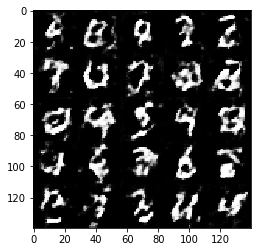

Epoch 310/0... Discriminator Loss: 2.0217... Generator Loss: 2.2268
Epoch 320/0... Discriminator Loss: 1.6146... Generator Loss: 0.7144
Epoch 330/0... Discriminator Loss: 1.5622... Generator Loss: 0.8617
Epoch 340/0... Discriminator Loss: 1.5220... Generator Loss: 0.8625
Epoch 350/0... Discriminator Loss: 1.4747... Generator Loss: 0.7312
Epoch 360/0... Discriminator Loss: 1.3373... Generator Loss: 0.7853
Epoch 370/0... Discriminator Loss: 1.4377... Generator Loss: 0.5653
Epoch 380/0... Discriminator Loss: 1.4618... Generator Loss: 0.7496
Epoch 390/0... Discriminator Loss: 1.5082... Generator Loss: 0.5947
Epoch 400/0... Discriminator Loss: 1.3576... Generator Loss: 0.8691


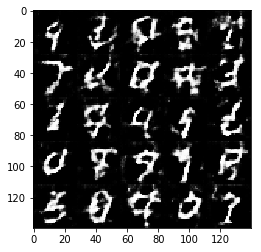

Epoch 410/0... Discriminator Loss: 1.2885... Generator Loss: 0.9359
Epoch 420/0... Discriminator Loss: 1.5500... Generator Loss: 0.6833
Epoch 430/0... Discriminator Loss: 1.4247... Generator Loss: 0.6021
Epoch 440/0... Discriminator Loss: 1.6089... Generator Loss: 0.7084
Epoch 450/0... Discriminator Loss: 1.4528... Generator Loss: 0.5475
Epoch 460/0... Discriminator Loss: 1.5358... Generator Loss: 0.4276
Epoch 470/0... Discriminator Loss: 1.5644... Generator Loss: 1.1473
Epoch 480/0... Discriminator Loss: 1.4399... Generator Loss: 0.7158
Epoch 490/0... Discriminator Loss: 1.6326... Generator Loss: 0.5077
Epoch 500/0... Discriminator Loss: 1.4598... Generator Loss: 0.6260


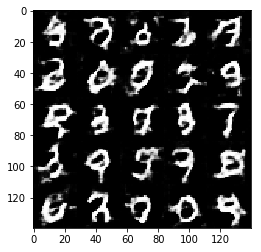

Epoch 510/0... Discriminator Loss: 1.5714... Generator Loss: 1.2679
Epoch 520/0... Discriminator Loss: 1.5905... Generator Loss: 0.5307
Epoch 530/0... Discriminator Loss: 1.5384... Generator Loss: 0.6444
Epoch 540/0... Discriminator Loss: 1.6515... Generator Loss: 1.4484
Epoch 550/0... Discriminator Loss: 1.3303... Generator Loss: 0.8930
Epoch 560/0... Discriminator Loss: 1.4717... Generator Loss: 0.5540
Epoch 570/0... Discriminator Loss: 1.4033... Generator Loss: 0.7379
Epoch 580/0... Discriminator Loss: 1.4869... Generator Loss: 0.7588
Epoch 590/0... Discriminator Loss: 1.7665... Generator Loss: 0.3572
Epoch 600/0... Discriminator Loss: 1.6100... Generator Loss: 0.5322


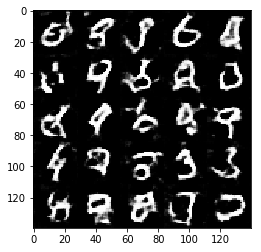

Epoch 610/0... Discriminator Loss: 1.4544... Generator Loss: 1.0135
Epoch 620/0... Discriminator Loss: 1.5397... Generator Loss: 0.5512
Epoch 630/0... Discriminator Loss: 1.5278... Generator Loss: 0.6080
Epoch 640/0... Discriminator Loss: 1.4730... Generator Loss: 0.6505
Epoch 650/0... Discriminator Loss: 1.4354... Generator Loss: 0.9588
Epoch 660/0... Discriminator Loss: 1.4011... Generator Loss: 0.6800
Epoch 670/0... Discriminator Loss: 1.5843... Generator Loss: 0.5636
Epoch 680/0... Discriminator Loss: 1.5774... Generator Loss: 0.4549
Epoch 690/0... Discriminator Loss: 1.3873... Generator Loss: 0.6259
Epoch 700/0... Discriminator Loss: 1.3892... Generator Loss: 0.6415


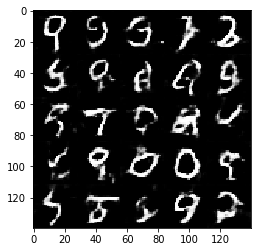

Epoch 710/0... Discriminator Loss: 1.5441... Generator Loss: 0.4670
Epoch 720/0... Discriminator Loss: 1.5029... Generator Loss: 0.6077
Epoch 730/0... Discriminator Loss: 1.4165... Generator Loss: 0.6266
Epoch 740/0... Discriminator Loss: 1.3279... Generator Loss: 0.8421
Epoch 750/0... Discriminator Loss: 1.3989... Generator Loss: 0.8004
Epoch 760/0... Discriminator Loss: 1.5934... Generator Loss: 0.7312
Epoch 770/0... Discriminator Loss: 1.5728... Generator Loss: 1.4932
Epoch 780/0... Discriminator Loss: 1.4724... Generator Loss: 0.8201
Epoch 790/0... Discriminator Loss: 1.5071... Generator Loss: 0.6533
Epoch 800/0... Discriminator Loss: 1.2991... Generator Loss: 0.8744


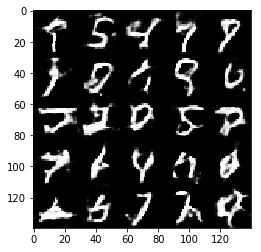

Epoch 810/0... Discriminator Loss: 1.4913... Generator Loss: 0.5391
Epoch 820/0... Discriminator Loss: 1.4666... Generator Loss: 0.7814
Epoch 830/0... Discriminator Loss: 1.4752... Generator Loss: 0.7185
Epoch 840/0... Discriminator Loss: 1.3877... Generator Loss: 0.7137
Epoch 850/0... Discriminator Loss: 1.2643... Generator Loss: 0.7718
Epoch 860/0... Discriminator Loss: 1.4981... Generator Loss: 0.6685
Epoch 870/0... Discriminator Loss: 1.4534... Generator Loss: 0.8957
Epoch 880/0... Discriminator Loss: 1.5395... Generator Loss: 0.7486
Epoch 890/0... Discriminator Loss: 1.2134... Generator Loss: 0.7999
Epoch 900/0... Discriminator Loss: 1.3017... Generator Loss: 0.6822


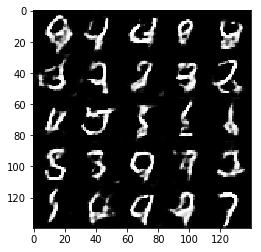

Epoch 910/0... Discriminator Loss: 1.4215... Generator Loss: 0.6235
Epoch 920/0... Discriminator Loss: 1.4331... Generator Loss: 0.5919
Epoch 930/0... Discriminator Loss: 1.5230... Generator Loss: 0.4761
Epoch 940/0... Discriminator Loss: 1.5352... Generator Loss: 0.5728
Epoch 950/0... Discriminator Loss: 1.3652... Generator Loss: 0.7801
Epoch 960/0... Discriminator Loss: 1.3939... Generator Loss: 0.8004
Epoch 970/0... Discriminator Loss: 1.5656... Generator Loss: 0.5851
Epoch 980/0... Discriminator Loss: 1.3845... Generator Loss: 0.6116
Epoch 990/0... Discriminator Loss: 1.2885... Generator Loss: 0.7117
Epoch 1000/0... Discriminator Loss: 1.3442... Generator Loss: 0.8852


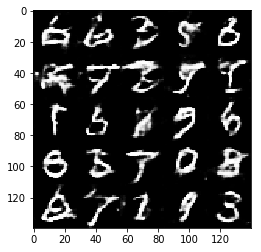

Epoch 1010/0... Discriminator Loss: 1.4813... Generator Loss: 0.5657
Epoch 1020/0... Discriminator Loss: 1.4951... Generator Loss: 0.6683
Epoch 1030/0... Discriminator Loss: 1.4592... Generator Loss: 0.5541
Epoch 1040/0... Discriminator Loss: 1.5760... Generator Loss: 0.5960
Epoch 1050/0... Discriminator Loss: 1.5588... Generator Loss: 0.5579
Epoch 1060/0... Discriminator Loss: 1.3164... Generator Loss: 0.6707
Epoch 1070/0... Discriminator Loss: 1.3634... Generator Loss: 0.5651
Epoch 1080/0... Discriminator Loss: 1.3490... Generator Loss: 0.7015
Epoch 1090/0... Discriminator Loss: 1.4124... Generator Loss: 0.9911
Epoch 1100/0... Discriminator Loss: 1.3685... Generator Loss: 1.1417


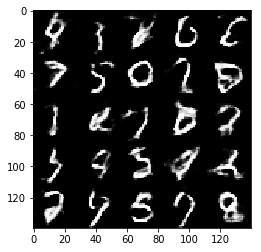

Epoch 1110/0... Discriminator Loss: 1.4664... Generator Loss: 0.8769
Epoch 1120/0... Discriminator Loss: 1.2614... Generator Loss: 1.1161
Epoch 1130/0... Discriminator Loss: 1.6660... Generator Loss: 0.5242
Epoch 1140/0... Discriminator Loss: 1.5040... Generator Loss: 0.6652
Epoch 1150/0... Discriminator Loss: 1.5292... Generator Loss: 0.5200
Epoch 1160/0... Discriminator Loss: 1.5463... Generator Loss: 0.5477
Epoch 1170/0... Discriminator Loss: 1.2679... Generator Loss: 0.8795
Epoch 1180/0... Discriminator Loss: 1.4367... Generator Loss: 0.7517
Epoch 1190/0... Discriminator Loss: 1.7762... Generator Loss: 1.0504
Epoch 1200/0... Discriminator Loss: 1.3780... Generator Loss: 0.7664


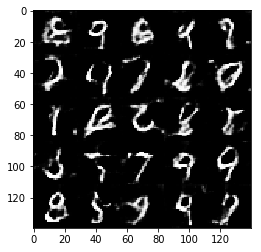

Epoch 1210/0... Discriminator Loss: 1.4401... Generator Loss: 0.6010
Epoch 1220/0... Discriminator Loss: 1.8316... Generator Loss: 0.3329
Epoch 1230/0... Discriminator Loss: 1.2376... Generator Loss: 0.7396
Epoch 1240/0... Discriminator Loss: 1.3375... Generator Loss: 0.6958
Epoch 1250/0... Discriminator Loss: 1.7192... Generator Loss: 0.3576
Epoch 1260/0... Discriminator Loss: 1.4181... Generator Loss: 0.6474
Epoch 1270/0... Discriminator Loss: 1.5649... Generator Loss: 0.6745
Epoch 1280/0... Discriminator Loss: 1.3943... Generator Loss: 0.4597
Epoch 1290/0... Discriminator Loss: 1.3349... Generator Loss: 1.0855
Epoch 1300/0... Discriminator Loss: 1.4410... Generator Loss: 0.6761


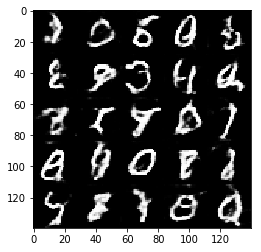

Epoch 1310/0... Discriminator Loss: 1.3413... Generator Loss: 1.5723
Epoch 1320/0... Discriminator Loss: 1.3043... Generator Loss: 0.7393
Epoch 1330/0... Discriminator Loss: 1.4109... Generator Loss: 0.6697
Epoch 1340/0... Discriminator Loss: 1.5856... Generator Loss: 0.5222
Epoch 1350/0... Discriminator Loss: 1.4054... Generator Loss: 0.7550
Epoch 1360/0... Discriminator Loss: 1.3691... Generator Loss: 0.7524
Epoch 1370/0... Discriminator Loss: 1.5790... Generator Loss: 0.6989
Epoch 1380/0... Discriminator Loss: 2.2152... Generator Loss: 0.2109
Epoch 1390/0... Discriminator Loss: 1.2131... Generator Loss: 0.9000
Epoch 1400/0... Discriminator Loss: 1.4819... Generator Loss: 0.7354


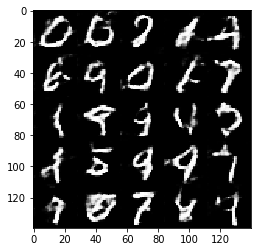

Epoch 1410/0... Discriminator Loss: 1.4156... Generator Loss: 0.4871
Epoch 1420/0... Discriminator Loss: 1.2105... Generator Loss: 1.1208
Epoch 1430/0... Discriminator Loss: 1.3004... Generator Loss: 1.6218
Epoch 1440/0... Discriminator Loss: 1.5040... Generator Loss: 0.6544
Epoch 1450/0... Discriminator Loss: 1.3274... Generator Loss: 0.5830
Epoch 1460/0... Discriminator Loss: 1.2807... Generator Loss: 1.0162
Epoch 1470/0... Discriminator Loss: 1.5293... Generator Loss: 0.8515
Epoch 1480/0... Discriminator Loss: 1.3526... Generator Loss: 0.5878
Epoch 1490/0... Discriminator Loss: 1.3014... Generator Loss: 1.0275
Epoch 1500/0... Discriminator Loss: 1.7741... Generator Loss: 2.4609


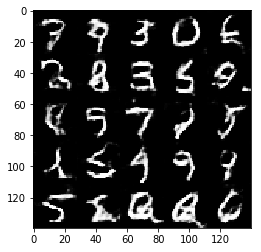

Epoch 1510/0... Discriminator Loss: 1.5211... Generator Loss: 0.7753
Epoch 1520/0... Discriminator Loss: 1.3988... Generator Loss: 0.8076
Epoch 1530/0... Discriminator Loss: 1.7343... Generator Loss: 0.3602
Epoch 1540/0... Discriminator Loss: 1.4748... Generator Loss: 0.5206
Epoch 1550/0... Discriminator Loss: 1.5508... Generator Loss: 0.5526
Epoch 1560/0... Discriminator Loss: 1.3424... Generator Loss: 0.8228
Epoch 1570/0... Discriminator Loss: 1.5500... Generator Loss: 0.5422
Epoch 1580/0... Discriminator Loss: 1.2793... Generator Loss: 0.8896
Epoch 1590/0... Discriminator Loss: 1.4500... Generator Loss: 0.6220
Epoch 1600/0... Discriminator Loss: 2.3036... Generator Loss: 0.1720


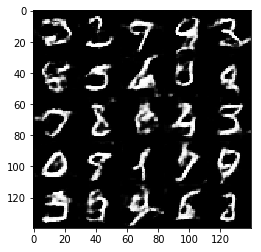

Epoch 1610/0... Discriminator Loss: 1.2959... Generator Loss: 0.8814
Epoch 1620/0... Discriminator Loss: 1.2602... Generator Loss: 0.8492
Epoch 1630/0... Discriminator Loss: 1.3978... Generator Loss: 0.8059
Epoch 1640/0... Discriminator Loss: 1.5648... Generator Loss: 0.8913
Epoch 1650/0... Discriminator Loss: 1.4090... Generator Loss: 0.7984
Epoch 1660/0... Discriminator Loss: 1.6626... Generator Loss: 0.3918
Epoch 1670/0... Discriminator Loss: 1.5116... Generator Loss: 0.5329
Epoch 1680/0... Discriminator Loss: 1.4529... Generator Loss: 0.7136
Epoch 1690/0... Discriminator Loss: 1.4579... Generator Loss: 0.6864
Epoch 1700/0... Discriminator Loss: 1.3682... Generator Loss: 0.7038


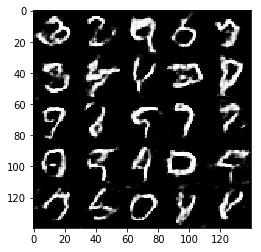

Epoch 1710/0... Discriminator Loss: 1.2594... Generator Loss: 0.7645
Epoch 1720/0... Discriminator Loss: 1.3330... Generator Loss: 0.6224
Epoch 1730/0... Discriminator Loss: 1.4609... Generator Loss: 0.6339
Epoch 1740/0... Discriminator Loss: 1.3450... Generator Loss: 0.6996
Epoch 1750/0... Discriminator Loss: 1.3292... Generator Loss: 0.9383
Epoch 1760/0... Discriminator Loss: 1.6391... Generator Loss: 0.4894
Epoch 1770/0... Discriminator Loss: 1.6454... Generator Loss: 0.5301
Epoch 1780/0... Discriminator Loss: 1.2081... Generator Loss: 0.9350
Epoch 1790/0... Discriminator Loss: 1.4210... Generator Loss: 0.7183
Epoch 1800/0... Discriminator Loss: 1.3190... Generator Loss: 1.0192


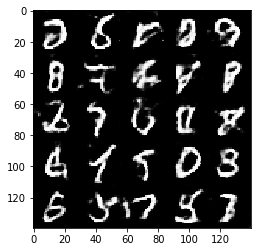

Epoch 1810/0... Discriminator Loss: 1.2980... Generator Loss: 0.7933
Epoch 1820/0... Discriminator Loss: 1.4458... Generator Loss: 0.5250
Epoch 1830/0... Discriminator Loss: 1.2910... Generator Loss: 1.1615
Epoch 1840/0... Discriminator Loss: 1.2990... Generator Loss: 0.9614
Epoch 1850/0... Discriminator Loss: 1.4982... Generator Loss: 0.9966
Epoch 1860/0... Discriminator Loss: 1.4115... Generator Loss: 0.7075
Epoch 1870/0... Discriminator Loss: 1.4048... Generator Loss: 0.7305
Epoch 1880/1... Discriminator Loss: 1.1709... Generator Loss: 0.8703
Epoch 1890/1... Discriminator Loss: 1.7755... Generator Loss: 0.4383
Epoch 1900/1... Discriminator Loss: 1.4357... Generator Loss: 0.5436


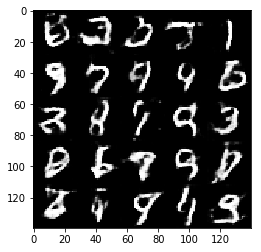

Epoch 1910/1... Discriminator Loss: 1.4200... Generator Loss: 0.6356
Epoch 1920/1... Discriminator Loss: 1.4603... Generator Loss: 1.7809
Epoch 1930/1... Discriminator Loss: 1.1945... Generator Loss: 0.8058
Epoch 1940/1... Discriminator Loss: 1.3092... Generator Loss: 0.8885
Epoch 1950/1... Discriminator Loss: 1.4378... Generator Loss: 0.4444
Epoch 1960/1... Discriminator Loss: 1.5030... Generator Loss: 0.7924
Epoch 1970/1... Discriminator Loss: 1.5174... Generator Loss: 0.8226
Epoch 1980/1... Discriminator Loss: 1.3322... Generator Loss: 0.9343
Epoch 1990/1... Discriminator Loss: 1.1368... Generator Loss: 1.2253
Epoch 2000/1... Discriminator Loss: 1.3167... Generator Loss: 0.8542


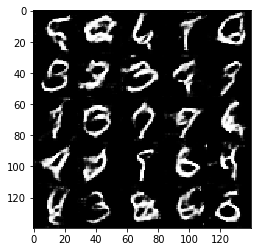

Epoch 2010/1... Discriminator Loss: 1.2079... Generator Loss: 1.1713
Epoch 2020/1... Discriminator Loss: 1.4476... Generator Loss: 0.9986
Epoch 2030/1... Discriminator Loss: 1.5048... Generator Loss: 0.9596
Epoch 2040/1... Discriminator Loss: 1.3371... Generator Loss: 0.7404
Epoch 2050/1... Discriminator Loss: 1.4031... Generator Loss: 0.5965
Epoch 2060/1... Discriminator Loss: 1.4384... Generator Loss: 0.4839
Epoch 2070/1... Discriminator Loss: 1.4794... Generator Loss: 0.5843
Epoch 2080/1... Discriminator Loss: 1.3939... Generator Loss: 0.6616
Epoch 2090/1... Discriminator Loss: 1.2333... Generator Loss: 0.7472
Epoch 2100/1... Discriminator Loss: 1.2643... Generator Loss: 0.8387


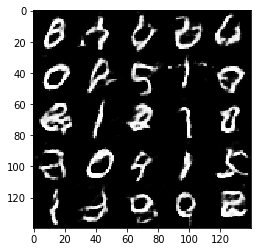

Epoch 2110/1... Discriminator Loss: 1.2461... Generator Loss: 0.7809
Epoch 2120/1... Discriminator Loss: 1.2557... Generator Loss: 0.9587
Epoch 2130/1... Discriminator Loss: 1.1602... Generator Loss: 0.7984
Epoch 2140/1... Discriminator Loss: 1.4025... Generator Loss: 1.2035
Epoch 2150/1... Discriminator Loss: 1.3262... Generator Loss: 1.0583
Epoch 2160/1... Discriminator Loss: 1.2254... Generator Loss: 0.7757
Epoch 2170/1... Discriminator Loss: 1.4574... Generator Loss: 1.1345
Epoch 2180/1... Discriminator Loss: 1.5594... Generator Loss: 0.6178
Epoch 2190/1... Discriminator Loss: 1.3060... Generator Loss: 0.9200
Epoch 2200/1... Discriminator Loss: 1.4818... Generator Loss: 0.4565


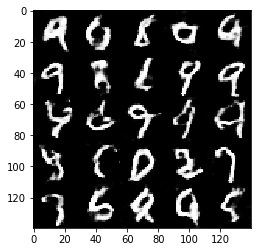

Epoch 2210/1... Discriminator Loss: 1.2403... Generator Loss: 0.8434
Epoch 2220/1... Discriminator Loss: 1.5313... Generator Loss: 1.0794
Epoch 2230/1... Discriminator Loss: 1.4197... Generator Loss: 0.9395
Epoch 2240/1... Discriminator Loss: 1.2084... Generator Loss: 0.8702
Epoch 2250/1... Discriminator Loss: 1.1316... Generator Loss: 1.2159
Epoch 2260/1... Discriminator Loss: 1.2276... Generator Loss: 0.6548
Epoch 2270/1... Discriminator Loss: 1.2424... Generator Loss: 1.2453
Epoch 2280/1... Discriminator Loss: 1.4681... Generator Loss: 0.7062
Epoch 2290/1... Discriminator Loss: 1.2668... Generator Loss: 1.1638
Epoch 2300/1... Discriminator Loss: 1.0081... Generator Loss: 1.5004


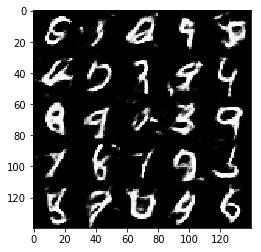

Epoch 2310/1... Discriminator Loss: 1.4437... Generator Loss: 0.7479
Epoch 2320/1... Discriminator Loss: 1.4232... Generator Loss: 0.9939
Epoch 2330/1... Discriminator Loss: 1.3504... Generator Loss: 1.0357
Epoch 2340/1... Discriminator Loss: 1.3348... Generator Loss: 1.1390
Epoch 2350/1... Discriminator Loss: 1.3070... Generator Loss: 0.8152
Epoch 2360/1... Discriminator Loss: 1.2947... Generator Loss: 0.9083
Epoch 2370/1... Discriminator Loss: 1.4412... Generator Loss: 0.9850
Epoch 2380/1... Discriminator Loss: 1.2045... Generator Loss: 1.6431
Epoch 2390/1... Discriminator Loss: 1.1899... Generator Loss: 1.2548
Epoch 2400/1... Discriminator Loss: 1.4595... Generator Loss: 0.6075


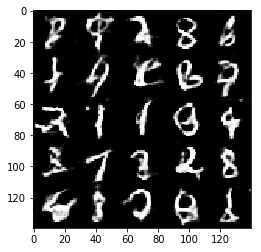

Epoch 2410/1... Discriminator Loss: 1.3955... Generator Loss: 0.7937
Epoch 2420/1... Discriminator Loss: 1.3389... Generator Loss: 1.0186
Epoch 2430/1... Discriminator Loss: 1.3019... Generator Loss: 0.7478
Epoch 2440/1... Discriminator Loss: 1.2365... Generator Loss: 0.6901
Epoch 2450/1... Discriminator Loss: 1.2312... Generator Loss: 0.9703
Epoch 2460/1... Discriminator Loss: 1.4462... Generator Loss: 1.0150
Epoch 2470/1... Discriminator Loss: 1.0804... Generator Loss: 1.0338
Epoch 2480/1... Discriminator Loss: 1.3045... Generator Loss: 0.9157
Epoch 2490/1... Discriminator Loss: 1.5121... Generator Loss: 0.5652
Epoch 2500/1... Discriminator Loss: 1.7745... Generator Loss: 0.3545


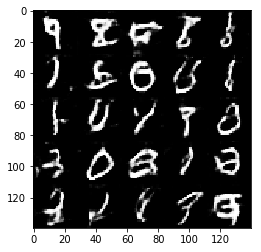

Epoch 2510/1... Discriminator Loss: 1.5079... Generator Loss: 0.5190
Epoch 2520/1... Discriminator Loss: 1.4215... Generator Loss: 0.6158
Epoch 2530/1... Discriminator Loss: 1.0469... Generator Loss: 0.8705
Epoch 2540/1... Discriminator Loss: 1.1605... Generator Loss: 1.3200
Epoch 2550/1... Discriminator Loss: 1.2228... Generator Loss: 1.0141
Epoch 2560/1... Discriminator Loss: 0.9894... Generator Loss: 1.0707
Epoch 2570/1... Discriminator Loss: 1.3313... Generator Loss: 1.0928
Epoch 2580/1... Discriminator Loss: 1.0337... Generator Loss: 1.0070
Epoch 2590/1... Discriminator Loss: 1.3645... Generator Loss: 0.7229
Epoch 2600/1... Discriminator Loss: 1.3353... Generator Loss: 0.8572


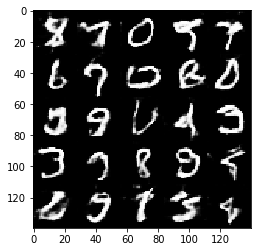

Epoch 2610/1... Discriminator Loss: 1.1269... Generator Loss: 0.9954
Epoch 2620/1... Discriminator Loss: 1.2647... Generator Loss: 1.2891
Epoch 2630/1... Discriminator Loss: 1.0913... Generator Loss: 0.9812
Epoch 2640/1... Discriminator Loss: 1.1573... Generator Loss: 1.2481
Epoch 2650/1... Discriminator Loss: 1.3984... Generator Loss: 2.0919
Epoch 2660/1... Discriminator Loss: 1.2032... Generator Loss: 1.0349
Epoch 2670/1... Discriminator Loss: 1.4231... Generator Loss: 0.6084
Epoch 2680/1... Discriminator Loss: 1.1739... Generator Loss: 0.8314
Epoch 2690/1... Discriminator Loss: 1.8529... Generator Loss: 0.6705
Epoch 2700/1... Discriminator Loss: 1.5378... Generator Loss: 0.6222


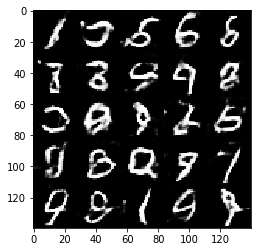

Epoch 2710/1... Discriminator Loss: 1.3198... Generator Loss: 0.7075
Epoch 2720/1... Discriminator Loss: 1.3834... Generator Loss: 0.6067
Epoch 2730/1... Discriminator Loss: 1.3624... Generator Loss: 0.7763
Epoch 2740/1... Discriminator Loss: 1.5005... Generator Loss: 1.6341
Epoch 2750/1... Discriminator Loss: 1.2373... Generator Loss: 1.1522
Epoch 2760/1... Discriminator Loss: 1.2429... Generator Loss: 1.2015
Epoch 2770/1... Discriminator Loss: 1.2079... Generator Loss: 1.0521
Epoch 2780/1... Discriminator Loss: 1.3105... Generator Loss: 0.9190
Epoch 2790/1... Discriminator Loss: 1.1788... Generator Loss: 0.6876
Epoch 2800/1... Discriminator Loss: 1.3727... Generator Loss: 0.6814


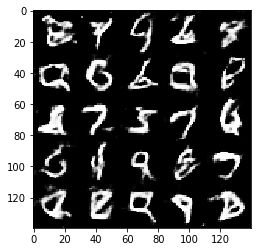

Epoch 2810/1... Discriminator Loss: 1.1442... Generator Loss: 1.1326
Epoch 2820/1... Discriminator Loss: 1.2598... Generator Loss: 0.8047
Epoch 2830/1... Discriminator Loss: 1.1737... Generator Loss: 0.8655
Epoch 2840/1... Discriminator Loss: 1.7218... Generator Loss: 1.9416
Epoch 2850/1... Discriminator Loss: 1.5181... Generator Loss: 0.7384
Epoch 2860/1... Discriminator Loss: 1.4162... Generator Loss: 0.6383
Epoch 2870/1... Discriminator Loss: 1.2672... Generator Loss: 1.0691
Epoch 2880/1... Discriminator Loss: 1.4070... Generator Loss: 0.7993
Epoch 2890/1... Discriminator Loss: 1.1146... Generator Loss: 0.9161
Epoch 2900/1... Discriminator Loss: 1.2327... Generator Loss: 1.7955


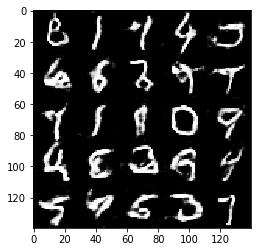

Epoch 2910/1... Discriminator Loss: 1.1406... Generator Loss: 1.3416
Epoch 2920/1... Discriminator Loss: 1.1463... Generator Loss: 1.3861
Epoch 2930/1... Discriminator Loss: 1.1886... Generator Loss: 0.9244
Epoch 2940/1... Discriminator Loss: 1.3576... Generator Loss: 1.3584
Epoch 2950/1... Discriminator Loss: 1.9543... Generator Loss: 0.3354
Epoch 2960/1... Discriminator Loss: 1.0980... Generator Loss: 1.2605
Epoch 2970/1... Discriminator Loss: 1.2805... Generator Loss: 1.1341
Epoch 2980/1... Discriminator Loss: 1.1980... Generator Loss: 1.0583
Epoch 2990/1... Discriminator Loss: 1.1492... Generator Loss: 1.3404
Epoch 3000/1... Discriminator Loss: 1.5175... Generator Loss: 0.5080


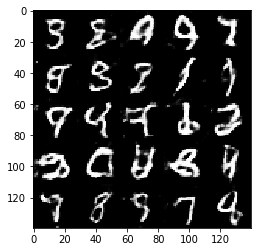

Epoch 3010/1... Discriminator Loss: 1.1835... Generator Loss: 0.8490
Epoch 3020/1... Discriminator Loss: 1.4413... Generator Loss: 0.7760
Epoch 3030/1... Discriminator Loss: 1.1444... Generator Loss: 1.3091
Epoch 3040/1... Discriminator Loss: 1.2359... Generator Loss: 0.8723
Epoch 3050/1... Discriminator Loss: 1.1530... Generator Loss: 1.1806
Epoch 3060/1... Discriminator Loss: 1.2661... Generator Loss: 0.8191
Epoch 3070/1... Discriminator Loss: 1.1365... Generator Loss: 1.0126
Epoch 3080/1... Discriminator Loss: 1.1378... Generator Loss: 0.8396
Epoch 3090/1... Discriminator Loss: 1.5177... Generator Loss: 0.6748
Epoch 3100/1... Discriminator Loss: 1.3606... Generator Loss: 0.6316


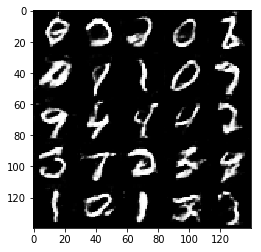

Epoch 3110/1... Discriminator Loss: 1.3230... Generator Loss: 0.7132
Epoch 3120/1... Discriminator Loss: 1.4142... Generator Loss: 1.7599
Epoch 3130/1... Discriminator Loss: 1.2591... Generator Loss: 0.8788
Epoch 3140/1... Discriminator Loss: 0.9814... Generator Loss: 1.1585
Epoch 3150/1... Discriminator Loss: 1.4039... Generator Loss: 0.7527
Epoch 3160/1... Discriminator Loss: 1.1418... Generator Loss: 0.7334
Epoch 3170/1... Discriminator Loss: 1.2086... Generator Loss: 1.2854
Epoch 3180/1... Discriminator Loss: 1.1598... Generator Loss: 0.8408
Epoch 3190/1... Discriminator Loss: 1.1758... Generator Loss: 1.3137
Epoch 3200/1... Discriminator Loss: 1.5588... Generator Loss: 0.5094


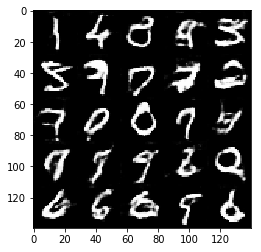

Epoch 3210/1... Discriminator Loss: 1.3152... Generator Loss: 0.9333
Epoch 3220/1... Discriminator Loss: 1.3766... Generator Loss: 0.7111
Epoch 3230/1... Discriminator Loss: 1.2111... Generator Loss: 1.2497
Epoch 3240/1... Discriminator Loss: 1.1276... Generator Loss: 1.4125
Epoch 3250/1... Discriminator Loss: 1.0902... Generator Loss: 0.8627
Epoch 3260/1... Discriminator Loss: 1.0461... Generator Loss: 1.8107
Epoch 3270/1... Discriminator Loss: 1.0476... Generator Loss: 1.2706
Epoch 3280/1... Discriminator Loss: 0.9992... Generator Loss: 1.0480
Epoch 3290/1... Discriminator Loss: 1.3759... Generator Loss: 0.6186
Epoch 3300/1... Discriminator Loss: 1.5040... Generator Loss: 0.5809


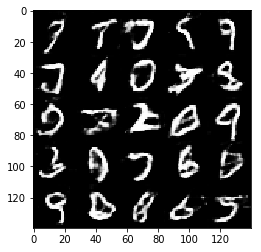

Epoch 3310/1... Discriminator Loss: 1.3920... Generator Loss: 0.5004
Epoch 3320/1... Discriminator Loss: 1.1714... Generator Loss: 1.1779
Epoch 3330/1... Discriminator Loss: 1.3011... Generator Loss: 0.5117
Epoch 3340/1... Discriminator Loss: 1.1789... Generator Loss: 0.7609
Epoch 3350/1... Discriminator Loss: 1.1221... Generator Loss: 0.8841
Epoch 3360/1... Discriminator Loss: 1.3524... Generator Loss: 0.7906
Epoch 3370/1... Discriminator Loss: 1.3542... Generator Loss: 0.8145
Epoch 3380/1... Discriminator Loss: 1.0841... Generator Loss: 0.9235
Epoch 3390/1... Discriminator Loss: 1.3963... Generator Loss: 0.8302
Epoch 3400/1... Discriminator Loss: 1.1493... Generator Loss: 1.0744


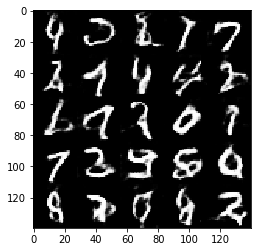

Epoch 3410/1... Discriminator Loss: 1.1659... Generator Loss: 1.0237
Epoch 3420/1... Discriminator Loss: 1.1087... Generator Loss: 1.1968
Epoch 3430/1... Discriminator Loss: 1.3697... Generator Loss: 0.9453
Epoch 3440/1... Discriminator Loss: 1.1832... Generator Loss: 1.2498
Epoch 3450/1... Discriminator Loss: 1.0320... Generator Loss: 1.1829
Epoch 3460/1... Discriminator Loss: 1.0354... Generator Loss: 0.9150
Epoch 3470/1... Discriminator Loss: 1.0944... Generator Loss: 1.5230
Epoch 3480/1... Discriminator Loss: 1.4913... Generator Loss: 1.6628
Epoch 3490/1... Discriminator Loss: 0.9968... Generator Loss: 1.5146
Epoch 3500/1... Discriminator Loss: 1.2180... Generator Loss: 0.7551


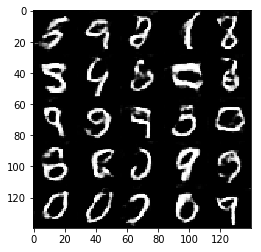

Epoch 3510/1... Discriminator Loss: 1.2372... Generator Loss: 0.8216
Epoch 3520/1... Discriminator Loss: 1.0724... Generator Loss: 1.1475
Epoch 3530/1... Discriminator Loss: 1.3799... Generator Loss: 1.9447
Epoch 3540/1... Discriminator Loss: 1.1691... Generator Loss: 0.6216
Epoch 3550/1... Discriminator Loss: 1.2504... Generator Loss: 1.6925
Epoch 3560/1... Discriminator Loss: 1.0976... Generator Loss: 1.5243
Epoch 3570/1... Discriminator Loss: 1.5698... Generator Loss: 0.4011
Epoch 3580/1... Discriminator Loss: 1.1841... Generator Loss: 0.8153
Epoch 3590/1... Discriminator Loss: 1.1215... Generator Loss: 1.2012
Epoch 3600/1... Discriminator Loss: 1.1240... Generator Loss: 0.8220


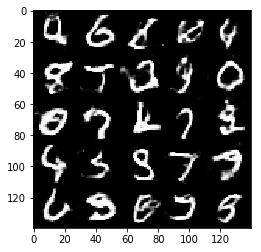

Epoch 3610/1... Discriminator Loss: 1.2632... Generator Loss: 0.8815
Epoch 3620/1... Discriminator Loss: 1.6038... Generator Loss: 0.5940
Epoch 3630/1... Discriminator Loss: 1.3091... Generator Loss: 0.9178
Epoch 3640/1... Discriminator Loss: 1.1616... Generator Loss: 1.4318
Epoch 3650/1... Discriminator Loss: 1.3400... Generator Loss: 1.5980
Epoch 3660/1... Discriminator Loss: 1.4485... Generator Loss: 0.5611
Epoch 3670/1... Discriminator Loss: 1.1716... Generator Loss: 0.8607
Epoch 3680/1... Discriminator Loss: 1.2524... Generator Loss: 1.6927
Epoch 3690/1... Discriminator Loss: 1.1363... Generator Loss: 0.8808
Epoch 3700/1... Discriminator Loss: 1.3955... Generator Loss: 0.7180


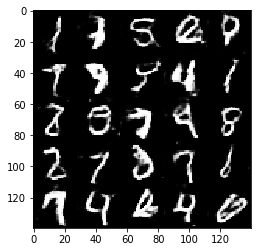

Epoch 3710/1... Discriminator Loss: 1.2332... Generator Loss: 0.8635
Epoch 3720/1... Discriminator Loss: 1.1903... Generator Loss: 0.9316
Epoch 3730/1... Discriminator Loss: 1.4197... Generator Loss: 0.6401
Epoch 3740/1... Discriminator Loss: 1.0682... Generator Loss: 1.0188
Epoch 3750/1... Discriminator Loss: 1.2067... Generator Loss: 1.4312


In [12]:
batch_size =32 #None
z_dim =128 #None
learning_rate =0.001 #None
beta1 =0.5 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 10/0... Discriminator Loss: 6.2321... Generator Loss: 0.0148
Epoch 20/0... Discriminator Loss: 4.8350... Generator Loss: 0.0459
Epoch 30/0... Discriminator Loss: 1.1789... Generator Loss: 12.3380
Epoch 40/0... Discriminator Loss: 4.5427... Generator Loss: 14.4259
Epoch 50/0... Discriminator Loss: 1.2243... Generator Loss: 1.0916
Epoch 60/0... Discriminator Loss: 4.7459... Generator Loss: 0.0340
Epoch 70/0... Discriminator Loss: 0.7410... Generator Loss: 1.5592
Epoch 80/0... Discriminator Loss: 0.7210... Generator Loss: 2.1181
Epoch 90/0... Discriminator Loss: 0.7217... Generator Loss: 2.1772
Epoch 100/0... Discriminator Loss: 2.1492... Generator Loss: 0.4105


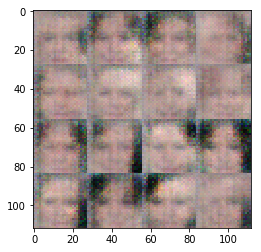

Epoch 110/0... Discriminator Loss: 1.3099... Generator Loss: 0.6277
Epoch 120/0... Discriminator Loss: 1.9469... Generator Loss: 0.2933
Epoch 130/0... Discriminator Loss: 1.4471... Generator Loss: 1.5912
Epoch 140/0... Discriminator Loss: 1.3689... Generator Loss: 0.8494
Epoch 150/0... Discriminator Loss: 1.3499... Generator Loss: 0.6725
Epoch 160/0... Discriminator Loss: 1.2153... Generator Loss: 0.7336
Epoch 170/0... Discriminator Loss: 1.4292... Generator Loss: 0.5036
Epoch 180/0... Discriminator Loss: 1.6055... Generator Loss: 0.5897
Epoch 190/0... Discriminator Loss: 1.4441... Generator Loss: 1.0507
Epoch 200/0... Discriminator Loss: 1.1995... Generator Loss: 0.8414


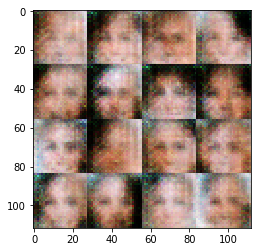

Epoch 210/0... Discriminator Loss: 1.5617... Generator Loss: 0.5259
Epoch 220/0... Discriminator Loss: 2.0611... Generator Loss: 0.3121
Epoch 230/0... Discriminator Loss: 1.8162... Generator Loss: 0.5061
Epoch 240/0... Discriminator Loss: 1.3977... Generator Loss: 0.7373
Epoch 250/0... Discriminator Loss: 1.5890... Generator Loss: 0.6090
Epoch 260/0... Discriminator Loss: 1.6998... Generator Loss: 0.6734
Epoch 270/0... Discriminator Loss: 1.3787... Generator Loss: 0.6667
Epoch 280/0... Discriminator Loss: 1.5686... Generator Loss: 0.6342
Epoch 290/0... Discriminator Loss: 1.4987... Generator Loss: 0.7146
Epoch 300/0... Discriminator Loss: 1.6152... Generator Loss: 0.6615


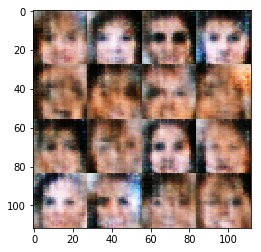

Epoch 310/0... Discriminator Loss: 1.5508... Generator Loss: 0.4525
Epoch 320/0... Discriminator Loss: 1.6295... Generator Loss: 0.3983
Epoch 330/0... Discriminator Loss: 1.7866... Generator Loss: 0.3894
Epoch 340/0... Discriminator Loss: 1.0681... Generator Loss: 1.1419
Epoch 350/0... Discriminator Loss: 1.3981... Generator Loss: 0.6798
Epoch 360/0... Discriminator Loss: 1.4122... Generator Loss: 0.6976
Epoch 370/0... Discriminator Loss: 1.5686... Generator Loss: 0.6681
Epoch 380/0... Discriminator Loss: 1.0235... Generator Loss: 1.3748
Epoch 390/0... Discriminator Loss: 1.1617... Generator Loss: 1.1846
Epoch 400/0... Discriminator Loss: 1.4724... Generator Loss: 0.7479


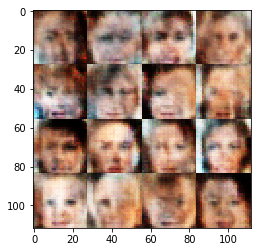

Epoch 410/0... Discriminator Loss: 2.1110... Generator Loss: 0.5171
Epoch 420/0... Discriminator Loss: 1.3044... Generator Loss: 0.8709
Epoch 430/0... Discriminator Loss: 1.2668... Generator Loss: 0.7741
Epoch 440/0... Discriminator Loss: 1.6226... Generator Loss: 0.4038
Epoch 450/0... Discriminator Loss: 1.3270... Generator Loss: 1.7848
Epoch 460/0... Discriminator Loss: 1.2662... Generator Loss: 1.3559
Epoch 470/0... Discriminator Loss: 1.2942... Generator Loss: 0.6747
Epoch 480/0... Discriminator Loss: 1.4721... Generator Loss: 0.5886
Epoch 490/0... Discriminator Loss: 1.2066... Generator Loss: 1.5625
Epoch 500/0... Discriminator Loss: 1.0462... Generator Loss: 0.9861


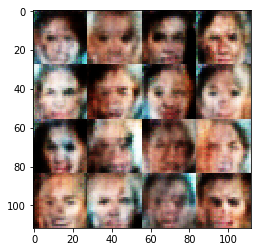

Epoch 510/0... Discriminator Loss: 1.0926... Generator Loss: 0.8387
Epoch 520/0... Discriminator Loss: 2.2028... Generator Loss: 0.3842
Epoch 530/0... Discriminator Loss: 1.7285... Generator Loss: 0.5755
Epoch 540/0... Discriminator Loss: 1.6727... Generator Loss: 0.4843
Epoch 550/0... Discriminator Loss: 1.5542... Generator Loss: 0.5148
Epoch 560/0... Discriminator Loss: 1.2499... Generator Loss: 0.7634
Epoch 570/0... Discriminator Loss: 1.3540... Generator Loss: 0.8085
Epoch 580/0... Discriminator Loss: 1.4388... Generator Loss: 0.6180
Epoch 590/0... Discriminator Loss: 1.4082... Generator Loss: 0.6227
Epoch 600/0... Discriminator Loss: 1.4059... Generator Loss: 0.6620


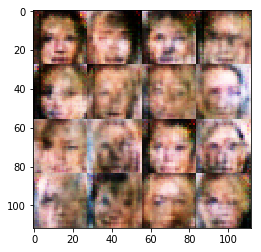

Epoch 610/0... Discriminator Loss: 1.3989... Generator Loss: 0.7833
Epoch 620/0... Discriminator Loss: 1.3859... Generator Loss: 0.7117
Epoch 630/0... Discriminator Loss: 1.4655... Generator Loss: 0.7211
Epoch 640/0... Discriminator Loss: 1.3595... Generator Loss: 0.8621
Epoch 650/0... Discriminator Loss: 1.3561... Generator Loss: 0.7219
Epoch 660/0... Discriminator Loss: 1.3802... Generator Loss: 0.7336
Epoch 670/0... Discriminator Loss: 1.4950... Generator Loss: 0.6271
Epoch 680/0... Discriminator Loss: 1.3783... Generator Loss: 0.8082
Epoch 690/0... Discriminator Loss: 1.5173... Generator Loss: 0.6765
Epoch 700/0... Discriminator Loss: 1.4310... Generator Loss: 0.7181


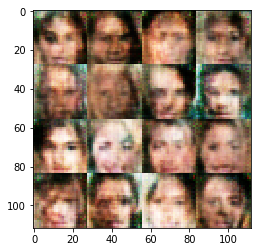

Epoch 710/0... Discriminator Loss: 1.4292... Generator Loss: 0.7321
Epoch 720/0... Discriminator Loss: 1.4172... Generator Loss: 0.7002
Epoch 730/0... Discriminator Loss: 1.4304... Generator Loss: 0.6751
Epoch 740/0... Discriminator Loss: 1.6242... Generator Loss: 0.6190
Epoch 750/0... Discriminator Loss: 1.4261... Generator Loss: 0.6230
Epoch 760/0... Discriminator Loss: 1.3656... Generator Loss: 0.8627
Epoch 770/0... Discriminator Loss: 1.4030... Generator Loss: 0.7179
Epoch 780/0... Discriminator Loss: 1.3222... Generator Loss: 0.8498
Epoch 790/0... Discriminator Loss: 1.4625... Generator Loss: 0.8853
Epoch 800/0... Discriminator Loss: 1.4566... Generator Loss: 0.7561


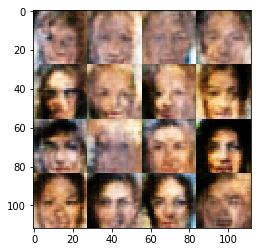

Epoch 810/0... Discriminator Loss: 1.2154... Generator Loss: 0.8598
Epoch 820/0... Discriminator Loss: 1.5082... Generator Loss: 0.6019
Epoch 830/0... Discriminator Loss: 1.2524... Generator Loss: 1.0598
Epoch 840/0... Discriminator Loss: 1.5027... Generator Loss: 0.7882
Epoch 850/0... Discriminator Loss: 1.3448... Generator Loss: 0.7786
Epoch 860/0... Discriminator Loss: 1.4550... Generator Loss: 0.6736
Epoch 870/0... Discriminator Loss: 1.4384... Generator Loss: 0.7569
Epoch 880/0... Discriminator Loss: 1.4935... Generator Loss: 0.5840
Epoch 890/0... Discriminator Loss: 1.4743... Generator Loss: 0.7610
Epoch 900/0... Discriminator Loss: 1.4992... Generator Loss: 0.6974


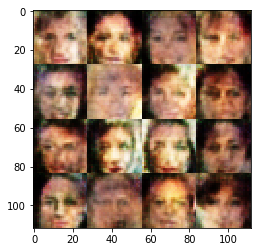

Epoch 910/0... Discriminator Loss: 1.4816... Generator Loss: 0.6238
Epoch 920/0... Discriminator Loss: 1.2367... Generator Loss: 0.9184
Epoch 930/0... Discriminator Loss: 1.4159... Generator Loss: 0.6650
Epoch 940/0... Discriminator Loss: 1.3967... Generator Loss: 0.7233
Epoch 950/0... Discriminator Loss: 1.3745... Generator Loss: 0.6543
Epoch 960/0... Discriminator Loss: 1.4864... Generator Loss: 0.6754
Epoch 970/0... Discriminator Loss: 1.4376... Generator Loss: 0.7446
Epoch 980/0... Discriminator Loss: 1.3503... Generator Loss: 0.8777
Epoch 990/0... Discriminator Loss: 1.3807... Generator Loss: 0.7113
Epoch 1000/0... Discriminator Loss: 1.3922... Generator Loss: 0.7018


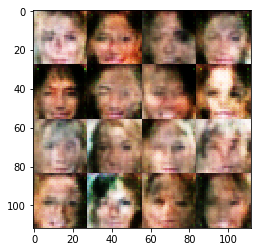

Epoch 1010/0... Discriminator Loss: 1.5314... Generator Loss: 0.6596
Epoch 1020/0... Discriminator Loss: 1.4069... Generator Loss: 0.7859
Epoch 1030/0... Discriminator Loss: 1.3726... Generator Loss: 0.7554
Epoch 1040/0... Discriminator Loss: 1.3771... Generator Loss: 0.6533
Epoch 1050/0... Discriminator Loss: 1.2093... Generator Loss: 1.5005
Epoch 1060/0... Discriminator Loss: 1.6058... Generator Loss: 0.4957
Epoch 1070/0... Discriminator Loss: 1.3169... Generator Loss: 0.7903
Epoch 1080/0... Discriminator Loss: 1.4530... Generator Loss: 0.8892
Epoch 1090/0... Discriminator Loss: 1.4954... Generator Loss: 0.6235
Epoch 1100/0... Discriminator Loss: 1.4460... Generator Loss: 0.7100


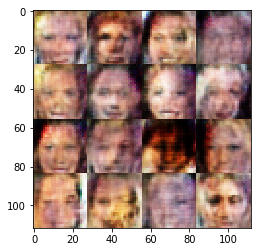

Epoch 1110/0... Discriminator Loss: 1.5195... Generator Loss: 0.7334
Epoch 1120/0... Discriminator Loss: 1.4597... Generator Loss: 0.6154
Epoch 1130/0... Discriminator Loss: 1.2789... Generator Loss: 0.9043
Epoch 1140/0... Discriminator Loss: 1.0823... Generator Loss: 1.6182
Epoch 1150/0... Discriminator Loss: 1.4408... Generator Loss: 0.5650
Epoch 1160/0... Discriminator Loss: 1.4385... Generator Loss: 0.7787
Epoch 1170/0... Discriminator Loss: 1.2830... Generator Loss: 0.9954
Epoch 1180/0... Discriminator Loss: 1.5138... Generator Loss: 0.7219
Epoch 1190/0... Discriminator Loss: 1.4607... Generator Loss: 0.6535
Epoch 1200/0... Discriminator Loss: 1.4307... Generator Loss: 0.7741


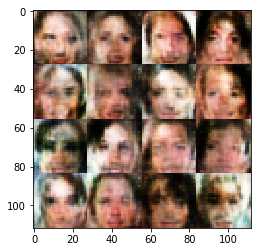

Epoch 1210/0... Discriminator Loss: 1.4759... Generator Loss: 0.6267
Epoch 1220/0... Discriminator Loss: 1.3779... Generator Loss: 0.6847
Epoch 1230/0... Discriminator Loss: 1.4817... Generator Loss: 0.5768
Epoch 1240/0... Discriminator Loss: 1.5218... Generator Loss: 0.7227
Epoch 1250/0... Discriminator Loss: 1.3302... Generator Loss: 0.7099
Epoch 1260/0... Discriminator Loss: 1.9414... Generator Loss: 0.9487
Epoch 1270/0... Discriminator Loss: 1.5031... Generator Loss: 0.6063
Epoch 1280/0... Discriminator Loss: 1.3656... Generator Loss: 0.7528
Epoch 1290/0... Discriminator Loss: 1.5344... Generator Loss: 0.6795
Epoch 1300/0... Discriminator Loss: 1.4101... Generator Loss: 0.7276


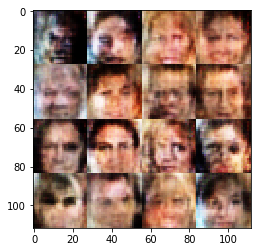

Epoch 1310/0... Discriminator Loss: 1.4688... Generator Loss: 0.6701
Epoch 1320/0... Discriminator Loss: 1.4049... Generator Loss: 0.7375
Epoch 1330/0... Discriminator Loss: 1.3380... Generator Loss: 0.9196
Epoch 1340/0... Discriminator Loss: 1.4297... Generator Loss: 0.6654
Epoch 1350/0... Discriminator Loss: 1.4078... Generator Loss: 0.6989
Epoch 1360/0... Discriminator Loss: 1.3432... Generator Loss: 0.7357
Epoch 1370/0... Discriminator Loss: 1.4321... Generator Loss: 0.7074
Epoch 1380/0... Discriminator Loss: 1.3339... Generator Loss: 0.6716
Epoch 1390/0... Discriminator Loss: 1.3621... Generator Loss: 0.7385
Epoch 1400/0... Discriminator Loss: 1.5413... Generator Loss: 0.6540


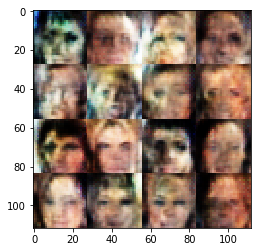

Epoch 1410/0... Discriminator Loss: 1.4700... Generator Loss: 0.6944
Epoch 1420/0... Discriminator Loss: 1.4306... Generator Loss: 0.8077
Epoch 1430/0... Discriminator Loss: 1.4478... Generator Loss: 0.6906
Epoch 1440/0... Discriminator Loss: 1.4344... Generator Loss: 0.6331
Epoch 1450/0... Discriminator Loss: 1.3693... Generator Loss: 0.7719
Epoch 1460/0... Discriminator Loss: 1.4979... Generator Loss: 0.6578
Epoch 1470/0... Discriminator Loss: 1.4090... Generator Loss: 0.7092
Epoch 1480/0... Discriminator Loss: 1.4430... Generator Loss: 0.6964
Epoch 1490/0... Discriminator Loss: 1.4272... Generator Loss: 0.7053
Epoch 1500/0... Discriminator Loss: 1.4284... Generator Loss: 0.6338


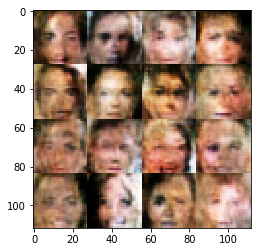

Epoch 1510/0... Discriminator Loss: 1.4364... Generator Loss: 0.7459
Epoch 1520/0... Discriminator Loss: 1.3263... Generator Loss: 0.8178
Epoch 1530/0... Discriminator Loss: 1.3696... Generator Loss: 0.7589
Epoch 1540/0... Discriminator Loss: 1.2746... Generator Loss: 0.9037
Epoch 1550/0... Discriminator Loss: 1.4869... Generator Loss: 0.5608
Epoch 1560/0... Discriminator Loss: 1.3182... Generator Loss: 0.7707
Epoch 1570/0... Discriminator Loss: 1.3698... Generator Loss: 0.7559
Epoch 1580/0... Discriminator Loss: 1.5411... Generator Loss: 0.6606
Epoch 1590/0... Discriminator Loss: 1.4750... Generator Loss: 0.5889
Epoch 1600/0... Discriminator Loss: 1.2837... Generator Loss: 0.9648


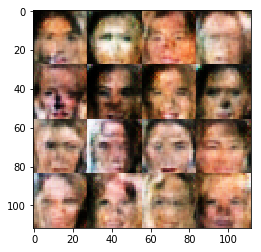

Epoch 1610/0... Discriminator Loss: 1.3097... Generator Loss: 0.8101
Epoch 1620/0... Discriminator Loss: 1.4774... Generator Loss: 0.8572
Epoch 1630/0... Discriminator Loss: 1.4701... Generator Loss: 0.6636
Epoch 1640/0... Discriminator Loss: 1.4049... Generator Loss: 0.7055
Epoch 1650/0... Discriminator Loss: 1.3775... Generator Loss: 0.7496
Epoch 1660/0... Discriminator Loss: 1.3975... Generator Loss: 0.8587
Epoch 1670/0... Discriminator Loss: 1.3179... Generator Loss: 0.7284
Epoch 1680/0... Discriminator Loss: 1.2173... Generator Loss: 0.6728
Epoch 1690/0... Discriminator Loss: 1.5403... Generator Loss: 0.6047
Epoch 1700/0... Discriminator Loss: 1.5199... Generator Loss: 0.5170


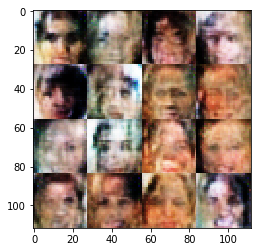

Epoch 1710/0... Discriminator Loss: 1.3531... Generator Loss: 0.6891
Epoch 1720/0... Discriminator Loss: 1.4201... Generator Loss: 0.6287
Epoch 1730/0... Discriminator Loss: 1.3848... Generator Loss: 0.7433
Epoch 1740/0... Discriminator Loss: 1.3563... Generator Loss: 0.6152
Epoch 1750/0... Discriminator Loss: 1.3319... Generator Loss: 0.8811
Epoch 1760/0... Discriminator Loss: 1.5242... Generator Loss: 0.6434
Epoch 1770/0... Discriminator Loss: 1.3693... Generator Loss: 0.7393
Epoch 1780/0... Discriminator Loss: 1.5952... Generator Loss: 0.5066
Epoch 1790/0... Discriminator Loss: 1.3984... Generator Loss: 0.6718
Epoch 1800/0... Discriminator Loss: 1.4448... Generator Loss: 0.6407


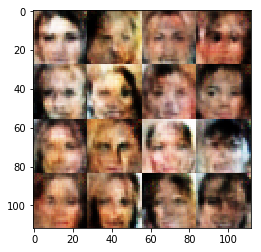

Epoch 1810/0... Discriminator Loss: 1.4792... Generator Loss: 0.7581
Epoch 1820/0... Discriminator Loss: 1.3896... Generator Loss: 0.7477
Epoch 1830/0... Discriminator Loss: 1.3779... Generator Loss: 0.8563
Epoch 1840/0... Discriminator Loss: 1.5652... Generator Loss: 0.5000
Epoch 1850/0... Discriminator Loss: 1.3256... Generator Loss: 0.7202
Epoch 1860/0... Discriminator Loss: 1.3525... Generator Loss: 0.8561
Epoch 1870/0... Discriminator Loss: 1.3721... Generator Loss: 0.7278
Epoch 1880/0... Discriminator Loss: 1.5971... Generator Loss: 0.7933
Epoch 1890/0... Discriminator Loss: 1.6015... Generator Loss: 0.6177
Epoch 1900/0... Discriminator Loss: 1.3814... Generator Loss: 0.7972


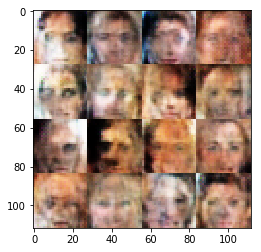

Epoch 1910/0... Discriminator Loss: 1.5017... Generator Loss: 0.5464
Epoch 1920/0... Discriminator Loss: 1.2065... Generator Loss: 1.0815
Epoch 1930/0... Discriminator Loss: 1.3844... Generator Loss: 0.6657
Epoch 1940/0... Discriminator Loss: 1.3336... Generator Loss: 0.8546
Epoch 1950/0... Discriminator Loss: 1.3763... Generator Loss: 0.6935
Epoch 1960/0... Discriminator Loss: 1.4008... Generator Loss: 0.6102
Epoch 1970/0... Discriminator Loss: 1.3717... Generator Loss: 0.7226
Epoch 1980/0... Discriminator Loss: 1.4084... Generator Loss: 0.7659
Epoch 1990/0... Discriminator Loss: 1.5521... Generator Loss: 0.6253
Epoch 2000/0... Discriminator Loss: 1.4074... Generator Loss: 0.7050


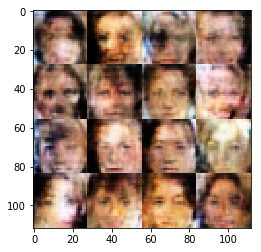

Epoch 2010/0... Discriminator Loss: 1.4392... Generator Loss: 0.6271
Epoch 2020/0... Discriminator Loss: 1.2026... Generator Loss: 0.7997
Epoch 2030/0... Discriminator Loss: 1.3265... Generator Loss: 0.7586
Epoch 2040/0... Discriminator Loss: 1.6025... Generator Loss: 0.7275
Epoch 2050/0... Discriminator Loss: 1.5010... Generator Loss: 0.5847
Epoch 2060/0... Discriminator Loss: 1.4537... Generator Loss: 0.4982
Epoch 2070/0... Discriminator Loss: 1.5808... Generator Loss: 0.6316
Epoch 2080/0... Discriminator Loss: 1.4541... Generator Loss: 0.6878
Epoch 2090/0... Discriminator Loss: 1.2667... Generator Loss: 1.0021
Epoch 2100/0... Discriminator Loss: 1.4938... Generator Loss: 0.7068


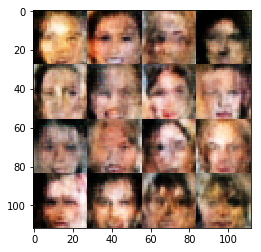

Epoch 2110/0... Discriminator Loss: 1.4664... Generator Loss: 0.8509
Epoch 2120/0... Discriminator Loss: 1.4638... Generator Loss: 0.6219
Epoch 2130/0... Discriminator Loss: 1.4639... Generator Loss: 0.7096
Epoch 2140/0... Discriminator Loss: 1.4414... Generator Loss: 0.5796
Epoch 2150/0... Discriminator Loss: 1.4564... Generator Loss: 0.7141
Epoch 2160/0... Discriminator Loss: 1.4577... Generator Loss: 0.6635
Epoch 2170/0... Discriminator Loss: 1.2740... Generator Loss: 0.7965
Epoch 2180/0... Discriminator Loss: 1.6571... Generator Loss: 0.7760
Epoch 2190/0... Discriminator Loss: 1.4049... Generator Loss: 0.6490
Epoch 2200/0... Discriminator Loss: 1.5679... Generator Loss: 0.6206


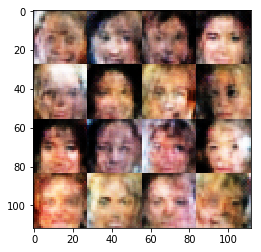

Epoch 2210/0... Discriminator Loss: 1.3967... Generator Loss: 0.7314
Epoch 2220/0... Discriminator Loss: 1.2732... Generator Loss: 0.7290
Epoch 2230/0... Discriminator Loss: 1.4269... Generator Loss: 0.7909
Epoch 2240/0... Discriminator Loss: 1.3098... Generator Loss: 0.6268
Epoch 2250/0... Discriminator Loss: 1.6007... Generator Loss: 0.7982
Epoch 2260/0... Discriminator Loss: 1.4753... Generator Loss: 0.7391
Epoch 2270/0... Discriminator Loss: 1.6560... Generator Loss: 0.7453
Epoch 2280/0... Discriminator Loss: 1.3853... Generator Loss: 0.7932
Epoch 2290/0... Discriminator Loss: 1.4903... Generator Loss: 1.3296
Epoch 2300/0... Discriminator Loss: 1.3840... Generator Loss: 0.7466


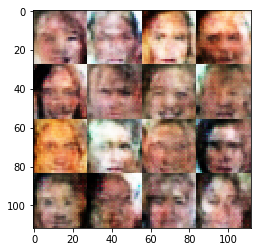

Epoch 2310/0... Discriminator Loss: 1.6223... Generator Loss: 0.6762
Epoch 2320/0... Discriminator Loss: 1.3389... Generator Loss: 0.7553
Epoch 2330/0... Discriminator Loss: 1.3121... Generator Loss: 0.5278
Epoch 2340/0... Discriminator Loss: 1.6305... Generator Loss: 0.6530
Epoch 2350/0... Discriminator Loss: 1.4565... Generator Loss: 0.7733
Epoch 2360/0... Discriminator Loss: 1.4568... Generator Loss: 0.7349
Epoch 2370/0... Discriminator Loss: 1.8143... Generator Loss: 0.8801
Epoch 2380/0... Discriminator Loss: 1.3880... Generator Loss: 0.7218
Epoch 2390/0... Discriminator Loss: 1.4382... Generator Loss: 0.7733
Epoch 2400/0... Discriminator Loss: 1.4455... Generator Loss: 0.6711


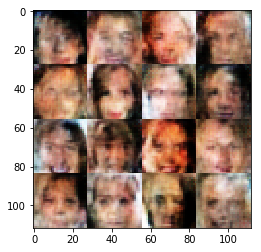

Epoch 2410/0... Discriminator Loss: 1.4765... Generator Loss: 0.5279
Epoch 2420/0... Discriminator Loss: 1.2934... Generator Loss: 0.7607
Epoch 2430/0... Discriminator Loss: 1.5564... Generator Loss: 0.5863
Epoch 2440/0... Discriminator Loss: 1.3745... Generator Loss: 0.7590
Epoch 2450/0... Discriminator Loss: 1.9376... Generator Loss: 0.8195
Epoch 2460/0... Discriminator Loss: 1.5064... Generator Loss: 0.5703
Epoch 2470/0... Discriminator Loss: 1.3546... Generator Loss: 0.8307
Epoch 2480/0... Discriminator Loss: 1.3249... Generator Loss: 0.8716
Epoch 2490/0... Discriminator Loss: 1.5387... Generator Loss: 0.6879
Epoch 2500/0... Discriminator Loss: 1.4794... Generator Loss: 0.6982


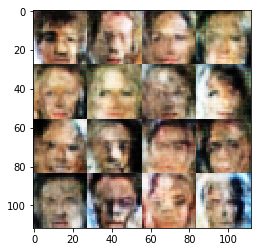

Epoch 2510/0... Discriminator Loss: 1.4962... Generator Loss: 0.5131
Epoch 2520/0... Discriminator Loss: 1.4219... Generator Loss: 0.7636
Epoch 2530/0... Discriminator Loss: 1.4425... Generator Loss: 0.5920
Epoch 2540/0... Discriminator Loss: 1.4086... Generator Loss: 0.6480
Epoch 2550/0... Discriminator Loss: 1.4151... Generator Loss: 0.7831
Epoch 2560/0... Discriminator Loss: 1.3836... Generator Loss: 0.7174
Epoch 2570/0... Discriminator Loss: 1.2305... Generator Loss: 0.9656
Epoch 2580/0... Discriminator Loss: 1.4387... Generator Loss: 0.6082
Epoch 2590/0... Discriminator Loss: 1.4404... Generator Loss: 0.6081
Epoch 2600/0... Discriminator Loss: 1.5142... Generator Loss: 0.6066


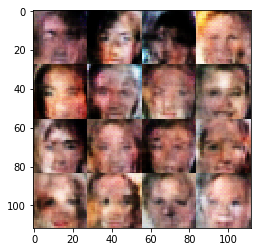

Epoch 2610/0... Discriminator Loss: 1.3505... Generator Loss: 0.6537
Epoch 2620/0... Discriminator Loss: 1.5254... Generator Loss: 0.5892
Epoch 2630/0... Discriminator Loss: 1.4494... Generator Loss: 0.7415
Epoch 2640/0... Discriminator Loss: 1.4010... Generator Loss: 0.5630
Epoch 2650/0... Discriminator Loss: 1.4885... Generator Loss: 0.6862
Epoch 2660/0... Discriminator Loss: 1.2680... Generator Loss: 0.7989
Epoch 2670/0... Discriminator Loss: 1.5011... Generator Loss: 0.6620
Epoch 2680/0... Discriminator Loss: 1.3536... Generator Loss: 0.7393
Epoch 2690/0... Discriminator Loss: 5.5680... Generator Loss: 0.2911
Epoch 2700/0... Discriminator Loss: 1.5043... Generator Loss: 0.5858


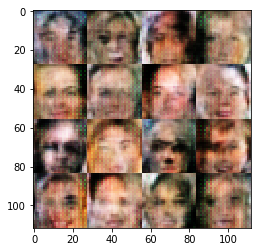

Epoch 2710/0... Discriminator Loss: 1.4969... Generator Loss: 0.6237
Epoch 2720/0... Discriminator Loss: 1.4156... Generator Loss: 0.6283
Epoch 2730/0... Discriminator Loss: 1.4720... Generator Loss: 0.6480
Epoch 2740/0... Discriminator Loss: 1.4359... Generator Loss: 0.6988
Epoch 2750/0... Discriminator Loss: 1.4622... Generator Loss: 0.6695
Epoch 2760/0... Discriminator Loss: 1.4786... Generator Loss: 0.6530
Epoch 2770/0... Discriminator Loss: 1.4276... Generator Loss: 0.6147
Epoch 2780/0... Discriminator Loss: 1.4411... Generator Loss: 0.6326
Epoch 2790/0... Discriminator Loss: 1.3266... Generator Loss: 0.7513
Epoch 2800/0... Discriminator Loss: 1.4825... Generator Loss: 0.7074


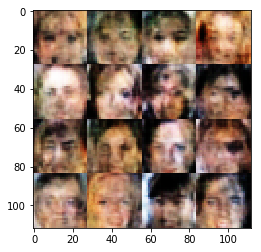

Epoch 2810/0... Discriminator Loss: 1.5038... Generator Loss: 0.5271
Epoch 2820/0... Discriminator Loss: 1.4284... Generator Loss: 0.7412
Epoch 2830/0... Discriminator Loss: 1.3760... Generator Loss: 0.7628
Epoch 2840/0... Discriminator Loss: 1.4455... Generator Loss: 0.7335
Epoch 2850/0... Discriminator Loss: 1.3384... Generator Loss: 0.6497
Epoch 2860/0... Discriminator Loss: 1.3091... Generator Loss: 0.7960
Epoch 2870/0... Discriminator Loss: 1.6025... Generator Loss: 0.3765
Epoch 2880/0... Discriminator Loss: 1.4654... Generator Loss: 0.6351
Epoch 2890/0... Discriminator Loss: 1.4513... Generator Loss: 0.8459
Epoch 2900/0... Discriminator Loss: 1.3162... Generator Loss: 0.7598


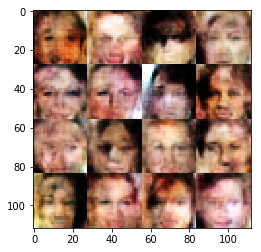

Epoch 2910/0... Discriminator Loss: 1.3866... Generator Loss: 0.6399
Epoch 2920/0... Discriminator Loss: 1.3549... Generator Loss: 0.9032
Epoch 2930/0... Discriminator Loss: 1.3537... Generator Loss: 0.8551
Epoch 2940/0... Discriminator Loss: 1.3400... Generator Loss: 0.8525
Epoch 2950/0... Discriminator Loss: 1.4464... Generator Loss: 0.7764
Epoch 2960/0... Discriminator Loss: 1.4064... Generator Loss: 0.7795
Epoch 2970/0... Discriminator Loss: 1.4420... Generator Loss: 0.5945
Epoch 2980/0... Discriminator Loss: 1.3702... Generator Loss: 0.6947
Epoch 2990/0... Discriminator Loss: 1.2382... Generator Loss: 0.9566
Epoch 3000/0... Discriminator Loss: 1.7093... Generator Loss: 0.8477


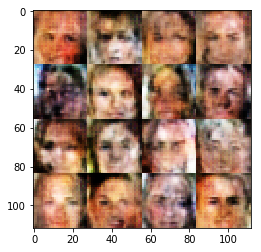

Epoch 3010/0... Discriminator Loss: 1.3953... Generator Loss: 0.8845
Epoch 3020/0... Discriminator Loss: 1.3184... Generator Loss: 0.8038
Epoch 3030/0... Discriminator Loss: 1.3523... Generator Loss: 0.7484
Epoch 3040/0... Discriminator Loss: 1.3575... Generator Loss: 0.8592
Epoch 3050/0... Discriminator Loss: 2.1588... Generator Loss: 0.7503
Epoch 3060/0... Discriminator Loss: 1.3525... Generator Loss: 0.8536
Epoch 3070/0... Discriminator Loss: 1.4308... Generator Loss: 0.6862
Epoch 3080/0... Discriminator Loss: 1.4599... Generator Loss: 0.6837
Epoch 3090/0... Discriminator Loss: 1.3786... Generator Loss: 0.7189
Epoch 3100/0... Discriminator Loss: 1.4411... Generator Loss: 0.6176


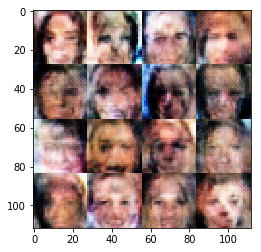

Epoch 3110/0... Discriminator Loss: 1.4498... Generator Loss: 0.7141
Epoch 3120/0... Discriminator Loss: 1.4326... Generator Loss: 0.7230
Epoch 3130/0... Discriminator Loss: 1.4236... Generator Loss: 0.8625
Epoch 3140/0... Discriminator Loss: 1.3931... Generator Loss: 0.7520
Epoch 3150/0... Discriminator Loss: 1.3383... Generator Loss: 0.8255
Epoch 3160/0... Discriminator Loss: 1.3767... Generator Loss: 0.8847
Epoch 3170/0... Discriminator Loss: 1.4102... Generator Loss: 0.7409
Epoch 3180/0... Discriminator Loss: 1.3686... Generator Loss: 0.6995
Epoch 3190/0... Discriminator Loss: 1.3036... Generator Loss: 0.8899
Epoch 3200/0... Discriminator Loss: 1.3391... Generator Loss: 0.8038


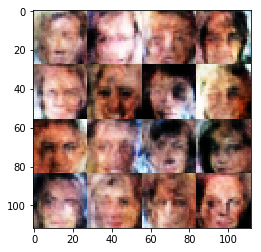

Epoch 3210/0... Discriminator Loss: 1.5155... Generator Loss: 0.8452
Epoch 3220/0... Discriminator Loss: 1.3594... Generator Loss: 0.8048
Epoch 3230/0... Discriminator Loss: 1.3792... Generator Loss: 0.7218
Epoch 3240/0... Discriminator Loss: 1.3567... Generator Loss: 0.6172
Epoch 3250/0... Discriminator Loss: 1.3609... Generator Loss: 0.9053
Epoch 3260/0... Discriminator Loss: 1.3352... Generator Loss: 0.8437
Epoch 3270/0... Discriminator Loss: 1.3931... Generator Loss: 0.6615
Epoch 3280/0... Discriminator Loss: 1.3501... Generator Loss: 0.6705
Epoch 3290/0... Discriminator Loss: 1.2802... Generator Loss: 0.7781
Epoch 3300/0... Discriminator Loss: 1.3351... Generator Loss: 0.8666


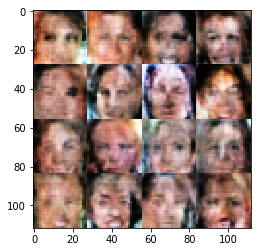

Epoch 3310/0... Discriminator Loss: 1.5094... Generator Loss: 0.6724
Epoch 3320/0... Discriminator Loss: 1.4669... Generator Loss: 0.6907
Epoch 3330/0... Discriminator Loss: 1.3751... Generator Loss: 0.9129
Epoch 3340/0... Discriminator Loss: 1.3864... Generator Loss: 0.7033
Epoch 3350/0... Discriminator Loss: 1.5664... Generator Loss: 0.4910
Epoch 3360/0... Discriminator Loss: 1.3782... Generator Loss: 0.7380
Epoch 3370/0... Discriminator Loss: 1.4008... Generator Loss: 0.8686
Epoch 3380/0... Discriminator Loss: 1.5451... Generator Loss: 0.7637
Epoch 3390/0... Discriminator Loss: 1.3708... Generator Loss: 0.8518
Epoch 3400/0... Discriminator Loss: 1.3179... Generator Loss: 0.8452


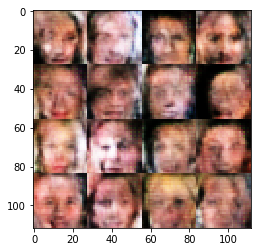

Epoch 3410/0... Discriminator Loss: 1.4544... Generator Loss: 0.6890
Epoch 3420/0... Discriminator Loss: 1.3497... Generator Loss: 0.7723
Epoch 3430/0... Discriminator Loss: 1.3438... Generator Loss: 0.6350
Epoch 3440/0... Discriminator Loss: 1.4719... Generator Loss: 0.6858
Epoch 3450/0... Discriminator Loss: 1.3351... Generator Loss: 0.8034
Epoch 3460/0... Discriminator Loss: 1.6004... Generator Loss: 0.9351
Epoch 3470/0... Discriminator Loss: 1.2559... Generator Loss: 0.8008
Epoch 3480/0... Discriminator Loss: 1.4079... Generator Loss: 0.6841
Epoch 3490/0... Discriminator Loss: 1.3353... Generator Loss: 0.9335
Epoch 3500/0... Discriminator Loss: 1.4275... Generator Loss: 0.6062


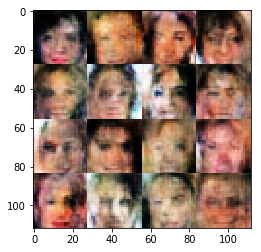

Epoch 3510/0... Discriminator Loss: 1.3903... Generator Loss: 0.6442
Epoch 3520/0... Discriminator Loss: 1.4191... Generator Loss: 0.7110
Epoch 3530/0... Discriminator Loss: 1.3313... Generator Loss: 0.7703
Epoch 3540/0... Discriminator Loss: 1.4774... Generator Loss: 0.4774
Epoch 3550/0... Discriminator Loss: 1.3301... Generator Loss: 0.7254
Epoch 3560/0... Discriminator Loss: 1.2089... Generator Loss: 0.6923
Epoch 3570/0... Discriminator Loss: 1.3883... Generator Loss: 0.7411
Epoch 3580/0... Discriminator Loss: 1.3670... Generator Loss: 0.7415
Epoch 3590/0... Discriminator Loss: 1.4177... Generator Loss: 0.7195
Epoch 3600/0... Discriminator Loss: 1.3060... Generator Loss: 0.8563


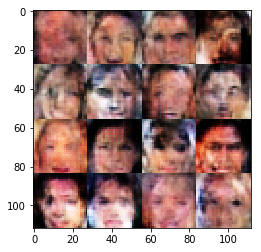

Epoch 3610/0... Discriminator Loss: 1.3706... Generator Loss: 0.9440
Epoch 3620/0... Discriminator Loss: 1.2956... Generator Loss: 0.8396
Epoch 3630/0... Discriminator Loss: 1.3098... Generator Loss: 0.8403
Epoch 3640/0... Discriminator Loss: 1.2479... Generator Loss: 0.7075
Epoch 3650/0... Discriminator Loss: 1.2903... Generator Loss: 0.7766
Epoch 3660/0... Discriminator Loss: 1.3328... Generator Loss: 0.8574
Epoch 3670/0... Discriminator Loss: 1.4503... Generator Loss: 0.7460
Epoch 3680/0... Discriminator Loss: 1.2668... Generator Loss: 0.7129
Epoch 3690/0... Discriminator Loss: 1.4768... Generator Loss: 0.6660
Epoch 3700/0... Discriminator Loss: 1.2545... Generator Loss: 0.8414


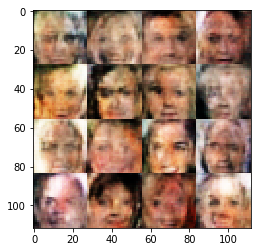

Epoch 3710/0... Discriminator Loss: 1.2502... Generator Loss: 0.7642
Epoch 3720/0... Discriminator Loss: 1.3804... Generator Loss: 0.7074
Epoch 3730/0... Discriminator Loss: 1.3022... Generator Loss: 0.9103
Epoch 3740/0... Discriminator Loss: 1.4425... Generator Loss: 0.9354
Epoch 3750/0... Discriminator Loss: 1.4999... Generator Loss: 0.8168
Epoch 3760/0... Discriminator Loss: 1.3167... Generator Loss: 0.7358
Epoch 3770/0... Discriminator Loss: 1.5098... Generator Loss: 0.6068
Epoch 3780/0... Discriminator Loss: 1.5019... Generator Loss: 0.7609
Epoch 3790/0... Discriminator Loss: 1.4372... Generator Loss: 0.7117
Epoch 3800/0... Discriminator Loss: 1.4339... Generator Loss: 0.7909


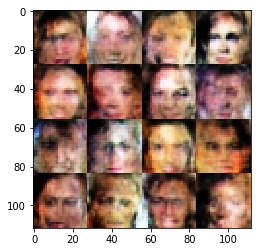

Epoch 3810/0... Discriminator Loss: 1.3704... Generator Loss: 0.7520
Epoch 3820/0... Discriminator Loss: 1.3860... Generator Loss: 0.7579
Epoch 3830/0... Discriminator Loss: 1.3711... Generator Loss: 0.7276
Epoch 3840/0... Discriminator Loss: 1.3605... Generator Loss: 0.9678
Epoch 3850/0... Discriminator Loss: 1.1911... Generator Loss: 0.8171
Epoch 3860/0... Discriminator Loss: 1.3601... Generator Loss: 0.6058
Epoch 3870/0... Discriminator Loss: 1.4230... Generator Loss: 0.7935
Epoch 3880/0... Discriminator Loss: 1.3500... Generator Loss: 0.7117
Epoch 3890/0... Discriminator Loss: 1.3534... Generator Loss: 0.8241
Epoch 3900/0... Discriminator Loss: 1.9062... Generator Loss: 0.7168


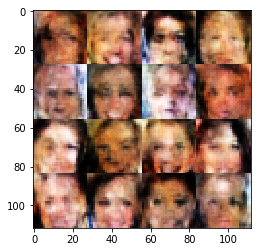

Epoch 3910/0... Discriminator Loss: 1.3188... Generator Loss: 0.8354
Epoch 3920/0... Discriminator Loss: 1.3249... Generator Loss: 0.8645
Epoch 3930/0... Discriminator Loss: 1.5177... Generator Loss: 0.6239
Epoch 3940/0... Discriminator Loss: 1.4604... Generator Loss: 0.6023
Epoch 3950/0... Discriminator Loss: 1.3315... Generator Loss: 0.7907
Epoch 3960/0... Discriminator Loss: 1.3157... Generator Loss: 0.8251
Epoch 3970/0... Discriminator Loss: 1.4642... Generator Loss: 0.8664
Epoch 3980/0... Discriminator Loss: 1.2349... Generator Loss: 0.8869
Epoch 3990/0... Discriminator Loss: 1.4088... Generator Loss: 0.6600
Epoch 4000/0... Discriminator Loss: 1.4316... Generator Loss: 0.6977


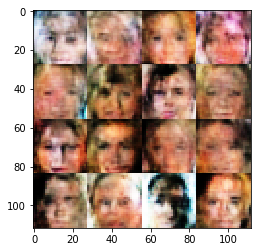

Epoch 4010/0... Discriminator Loss: 1.3850... Generator Loss: 0.7547
Epoch 4020/0... Discriminator Loss: 1.4466... Generator Loss: 0.6554
Epoch 4030/0... Discriminator Loss: 1.3970... Generator Loss: 0.5827
Epoch 4040/0... Discriminator Loss: 1.3162... Generator Loss: 0.8723
Epoch 4050/0... Discriminator Loss: 1.3272... Generator Loss: 0.8070
Epoch 4060/0... Discriminator Loss: 1.2734... Generator Loss: 0.9366
Epoch 4070/0... Discriminator Loss: 1.2974... Generator Loss: 0.7719
Epoch 4080/0... Discriminator Loss: 1.3539... Generator Loss: 0.6696
Epoch 4090/0... Discriminator Loss: 1.2327... Generator Loss: 0.8272
Epoch 4100/0... Discriminator Loss: 1.2364... Generator Loss: 0.7852


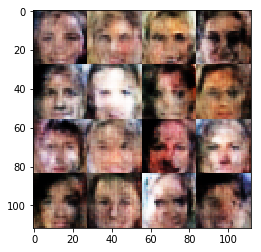

Epoch 4110/0... Discriminator Loss: 1.4418... Generator Loss: 0.7741
Epoch 4120/0... Discriminator Loss: 1.3990... Generator Loss: 0.7233
Epoch 4130/0... Discriminator Loss: 1.4111... Generator Loss: 0.7418
Epoch 4140/0... Discriminator Loss: 1.3168... Generator Loss: 0.9465
Epoch 4150/0... Discriminator Loss: 1.3832... Generator Loss: 0.6434
Epoch 4160/0... Discriminator Loss: 1.3181... Generator Loss: 0.8129
Epoch 4170/0... Discriminator Loss: 1.3751... Generator Loss: 0.7979
Epoch 4180/0... Discriminator Loss: 1.3803... Generator Loss: 0.7005
Epoch 4190/0... Discriminator Loss: 1.2754... Generator Loss: 0.9353
Epoch 4200/0... Discriminator Loss: 1.3520... Generator Loss: 0.7903


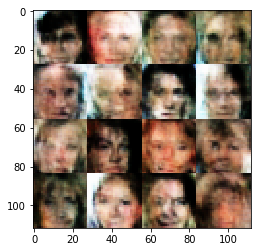

Epoch 4210/0... Discriminator Loss: 1.3817... Generator Loss: 0.7635
Epoch 4220/0... Discriminator Loss: 1.5451... Generator Loss: 0.6696
Epoch 4230/0... Discriminator Loss: 1.3889... Generator Loss: 0.7419
Epoch 4240/0... Discriminator Loss: 1.3566... Generator Loss: 0.8466
Epoch 4250/0... Discriminator Loss: 1.3188... Generator Loss: 0.5581
Epoch 4260/0... Discriminator Loss: 1.4061... Generator Loss: 0.9287
Epoch 4270/0... Discriminator Loss: 1.2132... Generator Loss: 0.8340
Epoch 4280/0... Discriminator Loss: 1.4079... Generator Loss: 0.7475
Epoch 4290/0... Discriminator Loss: 1.2226... Generator Loss: 0.8238
Epoch 4300/0... Discriminator Loss: 1.3610... Generator Loss: 0.7331


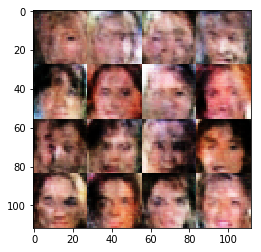

Epoch 4310/0... Discriminator Loss: 1.4186... Generator Loss: 0.9891
Epoch 4320/0... Discriminator Loss: 1.3686... Generator Loss: 0.7644
Epoch 4330/0... Discriminator Loss: 1.2883... Generator Loss: 0.6876
Epoch 4340/0... Discriminator Loss: 1.4102... Generator Loss: 0.9366
Epoch 4350/0... Discriminator Loss: 1.5775... Generator Loss: 0.5024
Epoch 4360/0... Discriminator Loss: 1.2380... Generator Loss: 0.7776
Epoch 4370/0... Discriminator Loss: 1.3270... Generator Loss: 0.9540
Epoch 4380/0... Discriminator Loss: 1.3665... Generator Loss: 0.8864
Epoch 4390/0... Discriminator Loss: 1.5704... Generator Loss: 0.9929
Epoch 4400/0... Discriminator Loss: 1.3658... Generator Loss: 0.6281


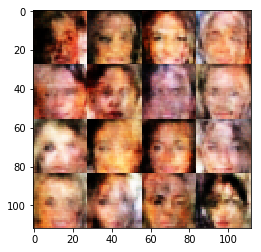

Epoch 4410/0... Discriminator Loss: 1.3697... Generator Loss: 0.6926
Epoch 4420/0... Discriminator Loss: 1.4824... Generator Loss: 0.4932
Epoch 4430/0... Discriminator Loss: 1.3952... Generator Loss: 0.9109
Epoch 4440/0... Discriminator Loss: 1.4539... Generator Loss: 0.6502
Epoch 4450/0... Discriminator Loss: 1.2955... Generator Loss: 0.6602
Epoch 4460/0... Discriminator Loss: 1.2904... Generator Loss: 0.8368
Epoch 4470/0... Discriminator Loss: 1.2337... Generator Loss: 1.0062
Epoch 4480/0... Discriminator Loss: 1.2114... Generator Loss: 0.7061
Epoch 4490/0... Discriminator Loss: 1.3579... Generator Loss: 0.7674
Epoch 4500/0... Discriminator Loss: 1.3280... Generator Loss: 0.8694


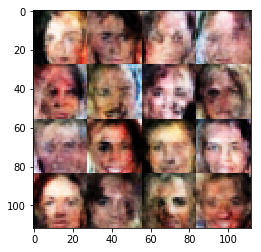

Epoch 4510/0... Discriminator Loss: 1.6198... Generator Loss: 0.7008
Epoch 4520/0... Discriminator Loss: 1.2898... Generator Loss: 0.9067
Epoch 4530/0... Discriminator Loss: 1.3323... Generator Loss: 0.7912
Epoch 4540/0... Discriminator Loss: 1.4469... Generator Loss: 0.7980
Epoch 4550/0... Discriminator Loss: 1.3987... Generator Loss: 0.6093
Epoch 4560/0... Discriminator Loss: 1.3959... Generator Loss: 0.6312
Epoch 4570/0... Discriminator Loss: 1.3099... Generator Loss: 0.7156
Epoch 4580/0... Discriminator Loss: 1.4035... Generator Loss: 0.7766
Epoch 4590/0... Discriminator Loss: 1.4034... Generator Loss: 0.6965
Epoch 4600/0... Discriminator Loss: 1.2893... Generator Loss: 0.8124


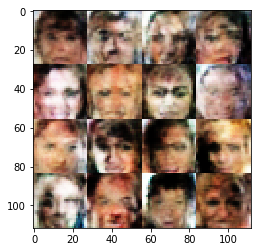

Epoch 4610/0... Discriminator Loss: 1.2858... Generator Loss: 1.0553
Epoch 4620/0... Discriminator Loss: 1.2905... Generator Loss: 0.8394
Epoch 4630/0... Discriminator Loss: 1.2946... Generator Loss: 0.9193
Epoch 4640/0... Discriminator Loss: 1.3673... Generator Loss: 0.8318
Epoch 4650/0... Discriminator Loss: 1.2923... Generator Loss: 0.8220
Epoch 4660/0... Discriminator Loss: 1.3867... Generator Loss: 0.7041
Epoch 4670/0... Discriminator Loss: 1.6837... Generator Loss: 0.7490
Epoch 4680/0... Discriminator Loss: 1.2605... Generator Loss: 0.8521
Epoch 4690/0... Discriminator Loss: 1.4227... Generator Loss: 0.6215
Epoch 4700/0... Discriminator Loss: 1.3042... Generator Loss: 1.0922


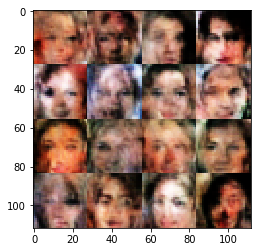

Epoch 4710/0... Discriminator Loss: 1.2133... Generator Loss: 0.7443
Epoch 4720/0... Discriminator Loss: 1.2701... Generator Loss: 0.9882
Epoch 4730/0... Discriminator Loss: 1.4186... Generator Loss: 0.6667
Epoch 4740/0... Discriminator Loss: 1.3653... Generator Loss: 0.8508
Epoch 4750/0... Discriminator Loss: 1.3189... Generator Loss: 0.9682
Epoch 4760/0... Discriminator Loss: 1.1705... Generator Loss: 0.8931
Epoch 4770/0... Discriminator Loss: 1.3791... Generator Loss: 0.9085
Epoch 4780/0... Discriminator Loss: 1.6152... Generator Loss: 0.7764
Epoch 4790/0... Discriminator Loss: 1.3430... Generator Loss: 0.7211
Epoch 4800/0... Discriminator Loss: 1.2021... Generator Loss: 1.0437


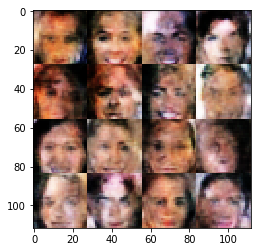

Epoch 4810/0... Discriminator Loss: 1.2655... Generator Loss: 0.8027
Epoch 4820/0... Discriminator Loss: 1.4250... Generator Loss: 0.7960
Epoch 4830/0... Discriminator Loss: 1.2817... Generator Loss: 0.6293
Epoch 4840/0... Discriminator Loss: 1.2756... Generator Loss: 0.7995
Epoch 4850/0... Discriminator Loss: 1.4235... Generator Loss: 0.8059
Epoch 4860/0... Discriminator Loss: 1.5041... Generator Loss: 0.6916
Epoch 4870/0... Discriminator Loss: 1.5231... Generator Loss: 0.8717
Epoch 4880/0... Discriminator Loss: 1.2274... Generator Loss: 0.9073
Epoch 4890/0... Discriminator Loss: 1.3001... Generator Loss: 0.8502
Epoch 4900/0... Discriminator Loss: 1.4820... Generator Loss: 0.6646


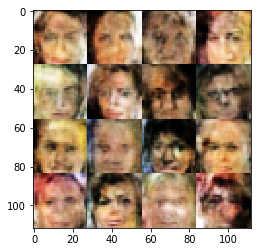

Epoch 4910/0... Discriminator Loss: 1.3133... Generator Loss: 0.8124
Epoch 4920/0... Discriminator Loss: 1.3564... Generator Loss: 0.7529
Epoch 4930/0... Discriminator Loss: 1.5289... Generator Loss: 0.7929
Epoch 4940/0... Discriminator Loss: 1.2644... Generator Loss: 0.8703
Epoch 4950/0... Discriminator Loss: 1.4793... Generator Loss: 0.5015
Epoch 4960/0... Discriminator Loss: 1.2099... Generator Loss: 0.7871
Epoch 4970/0... Discriminator Loss: 1.2461... Generator Loss: 0.9153
Epoch 4980/0... Discriminator Loss: 1.3123... Generator Loss: 0.8723
Epoch 4990/0... Discriminator Loss: 1.3205... Generator Loss: 0.7464
Epoch 5000/0... Discriminator Loss: 1.4106... Generator Loss: 0.8881


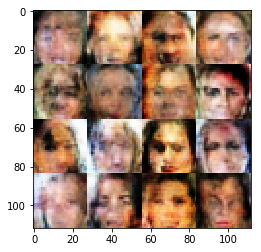

Epoch 5010/0... Discriminator Loss: 1.3265... Generator Loss: 0.9275
Epoch 5020/0... Discriminator Loss: 1.4346... Generator Loss: 0.7217
Epoch 5030/0... Discriminator Loss: 1.2007... Generator Loss: 0.7761
Epoch 5040/0... Discriminator Loss: 1.1869... Generator Loss: 0.8992
Epoch 5050/0... Discriminator Loss: 1.2462... Generator Loss: 0.9439
Epoch 5060/0... Discriminator Loss: 1.2599... Generator Loss: 0.9631
Epoch 5070/0... Discriminator Loss: 1.2815... Generator Loss: 0.9209
Epoch 5080/0... Discriminator Loss: 1.2031... Generator Loss: 0.7749
Epoch 5090/0... Discriminator Loss: 1.3264... Generator Loss: 0.9672
Epoch 5100/0... Discriminator Loss: 1.3057... Generator Loss: 0.8353


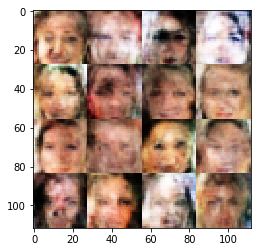

Epoch 5110/0... Discriminator Loss: 1.2523... Generator Loss: 0.9037
Epoch 5120/0... Discriminator Loss: 1.3090... Generator Loss: 0.7453
Epoch 5130/0... Discriminator Loss: 1.2300... Generator Loss: 0.9212
Epoch 5140/0... Discriminator Loss: 1.2228... Generator Loss: 0.6960
Epoch 5150/0... Discriminator Loss: 1.2403... Generator Loss: 0.7829
Epoch 5160/0... Discriminator Loss: 1.4498... Generator Loss: 0.9532
Epoch 5170/0... Discriminator Loss: 1.4143... Generator Loss: 0.9191
Epoch 5180/0... Discriminator Loss: 1.3458... Generator Loss: 0.6691
Epoch 5190/0... Discriminator Loss: 1.1973... Generator Loss: 0.9010
Epoch 5200/0... Discriminator Loss: 1.4218... Generator Loss: 0.7377


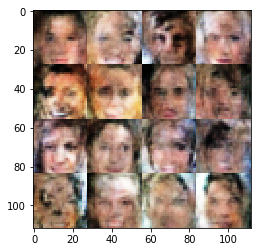

Epoch 5210/0... Discriminator Loss: 1.3164... Generator Loss: 0.6965
Epoch 5220/0... Discriminator Loss: 1.2490... Generator Loss: 0.8654
Epoch 5230/0... Discriminator Loss: 1.3379... Generator Loss: 0.6032
Epoch 5240/0... Discriminator Loss: 1.1348... Generator Loss: 0.8368
Epoch 5250/0... Discriminator Loss: 1.1847... Generator Loss: 0.8844
Epoch 5260/0... Discriminator Loss: 1.3613... Generator Loss: 1.0397
Epoch 5270/0... Discriminator Loss: 1.2549... Generator Loss: 0.8735
Epoch 5280/0... Discriminator Loss: 1.3847... Generator Loss: 0.6146
Epoch 5290/0... Discriminator Loss: 1.2521... Generator Loss: 0.8975
Epoch 5300/0... Discriminator Loss: 1.2040... Generator Loss: 1.0219


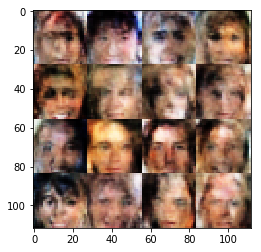

Epoch 5310/0... Discriminator Loss: 1.2375... Generator Loss: 0.6694
Epoch 5320/0... Discriminator Loss: 1.2770... Generator Loss: 0.6989
Epoch 5330/0... Discriminator Loss: 1.2932... Generator Loss: 1.0015
Epoch 5340/0... Discriminator Loss: 1.3482... Generator Loss: 0.8166
Epoch 5350/0... Discriminator Loss: 1.2540... Generator Loss: 1.1002
Epoch 5360/0... Discriminator Loss: 1.3192... Generator Loss: 1.0855
Epoch 5370/0... Discriminator Loss: 1.2698... Generator Loss: 0.8554
Epoch 5380/0... Discriminator Loss: 1.2496... Generator Loss: 0.8287
Epoch 5390/0... Discriminator Loss: 1.3177... Generator Loss: 0.7216
Epoch 5400/0... Discriminator Loss: 1.3939... Generator Loss: 0.7026


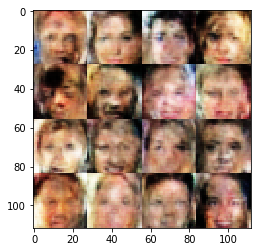

Epoch 5410/0... Discriminator Loss: 1.4665... Generator Loss: 0.8179
Epoch 5420/0... Discriminator Loss: 1.3102... Generator Loss: 0.9547
Epoch 5430/0... Discriminator Loss: 1.3060... Generator Loss: 0.5917
Epoch 5440/0... Discriminator Loss: 1.3228... Generator Loss: 0.8175
Epoch 5450/0... Discriminator Loss: 1.2581... Generator Loss: 0.9063
Epoch 5460/0... Discriminator Loss: 1.2000... Generator Loss: 1.1298
Epoch 5470/0... Discriminator Loss: 1.3517... Generator Loss: 0.9125
Epoch 5480/0... Discriminator Loss: 1.4329... Generator Loss: 0.7813
Epoch 5490/0... Discriminator Loss: 1.3053... Generator Loss: 0.7099
Epoch 5500/0... Discriminator Loss: 1.3787... Generator Loss: 0.8597


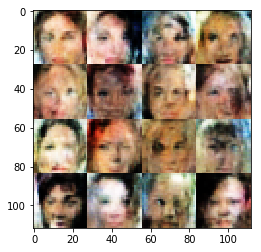

Epoch 5510/0... Discriminator Loss: 1.3418... Generator Loss: 0.7840
Epoch 5520/0... Discriminator Loss: 1.2655... Generator Loss: 0.6092
Epoch 5530/0... Discriminator Loss: 1.3288... Generator Loss: 0.8936
Epoch 5540/0... Discriminator Loss: 1.1257... Generator Loss: 0.8930
Epoch 5550/0... Discriminator Loss: 1.1882... Generator Loss: 1.0458
Epoch 5560/0... Discriminator Loss: 1.3502... Generator Loss: 0.9436
Epoch 5570/0... Discriminator Loss: 1.2276... Generator Loss: 0.9504
Epoch 5580/0... Discriminator Loss: 1.2984... Generator Loss: 0.9289
Epoch 5590/0... Discriminator Loss: 1.1481... Generator Loss: 0.8166
Epoch 5600/0... Discriminator Loss: 1.2815... Generator Loss: 0.7511


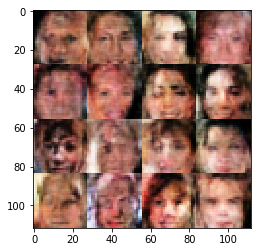

Epoch 5610/0... Discriminator Loss: 1.2035... Generator Loss: 0.8686
Epoch 5620/0... Discriminator Loss: 1.1352... Generator Loss: 0.8624
Epoch 5630/0... Discriminator Loss: 1.3878... Generator Loss: 0.9299
Epoch 5640/0... Discriminator Loss: 1.2765... Generator Loss: 0.6717
Epoch 5650/0... Discriminator Loss: 1.1341... Generator Loss: 1.0215
Epoch 5660/0... Discriminator Loss: 1.2819... Generator Loss: 0.7039
Epoch 5670/0... Discriminator Loss: 1.3506... Generator Loss: 0.8879
Epoch 5680/0... Discriminator Loss: 1.2908... Generator Loss: 0.6770
Epoch 5690/0... Discriminator Loss: 1.1230... Generator Loss: 0.8711
Epoch 5700/0... Discriminator Loss: 1.2145... Generator Loss: 0.9835


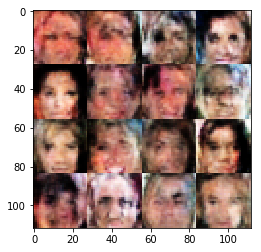

Epoch 5710/0... Discriminator Loss: 1.4961... Generator Loss: 0.6778
Epoch 5720/0... Discriminator Loss: 1.3708... Generator Loss: 0.8384
Epoch 5730/0... Discriminator Loss: 1.1146... Generator Loss: 0.9379
Epoch 5740/0... Discriminator Loss: 1.3240... Generator Loss: 0.6506
Epoch 5750/0... Discriminator Loss: 1.2062... Generator Loss: 1.1208
Epoch 5760/0... Discriminator Loss: 1.2119... Generator Loss: 1.0105
Epoch 5770/0... Discriminator Loss: 1.1618... Generator Loss: 1.0475
Epoch 5780/0... Discriminator Loss: 1.3469... Generator Loss: 1.1947
Epoch 5790/0... Discriminator Loss: 1.4086... Generator Loss: 0.9817
Epoch 5800/0... Discriminator Loss: 1.4377... Generator Loss: 0.8862


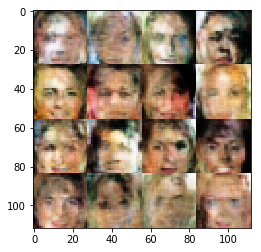

Epoch 5810/0... Discriminator Loss: 1.2636... Generator Loss: 0.9250
Epoch 5820/0... Discriminator Loss: 1.3453... Generator Loss: 0.9751
Epoch 5830/0... Discriminator Loss: 1.3507... Generator Loss: 1.1262
Epoch 5840/0... Discriminator Loss: 1.5177... Generator Loss: 0.6026
Epoch 5850/0... Discriminator Loss: 1.1815... Generator Loss: 0.9091
Epoch 5860/0... Discriminator Loss: 1.3248... Generator Loss: 1.1228
Epoch 5870/0... Discriminator Loss: 1.0571... Generator Loss: 1.1101
Epoch 5880/0... Discriminator Loss: 1.2707... Generator Loss: 0.7466
Epoch 5890/0... Discriminator Loss: 1.1335... Generator Loss: 0.9666
Epoch 5900/0... Discriminator Loss: 1.1927... Generator Loss: 0.9763


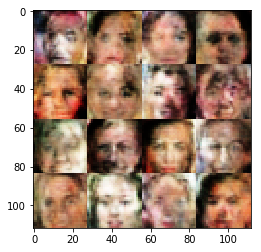

Epoch 5910/0... Discriminator Loss: 1.2193... Generator Loss: 0.7595
Epoch 5920/0... Discriminator Loss: 1.3722... Generator Loss: 0.9058
Epoch 5930/0... Discriminator Loss: 1.2925... Generator Loss: 0.8407
Epoch 5940/0... Discriminator Loss: 1.2705... Generator Loss: 1.1891
Epoch 5950/0... Discriminator Loss: 1.2747... Generator Loss: 0.9058
Epoch 5960/0... Discriminator Loss: 1.3044... Generator Loss: 0.8403
Epoch 5970/0... Discriminator Loss: 1.1743... Generator Loss: 0.8239
Epoch 5980/0... Discriminator Loss: 1.1525... Generator Loss: 0.8654
Epoch 5990/0... Discriminator Loss: 1.2795... Generator Loss: 0.6428
Epoch 6000/0... Discriminator Loss: 1.2567... Generator Loss: 0.8225


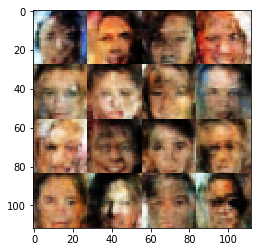

Epoch 6010/0... Discriminator Loss: 1.2741... Generator Loss: 1.0464
Epoch 6020/0... Discriminator Loss: 1.4716... Generator Loss: 0.8558
Epoch 6030/0... Discriminator Loss: 1.3270... Generator Loss: 0.9196
Epoch 6040/0... Discriminator Loss: 1.3061... Generator Loss: 0.8534
Epoch 6050/0... Discriminator Loss: 1.3329... Generator Loss: 0.7506
Epoch 6060/0... Discriminator Loss: 1.1926... Generator Loss: 0.9783
Epoch 6070/0... Discriminator Loss: 1.2611... Generator Loss: 0.8230
Epoch 6080/0... Discriminator Loss: 1.2500... Generator Loss: 1.0021
Epoch 6090/0... Discriminator Loss: 1.3735... Generator Loss: 1.0432
Epoch 6100/0... Discriminator Loss: 1.1803... Generator Loss: 0.7777


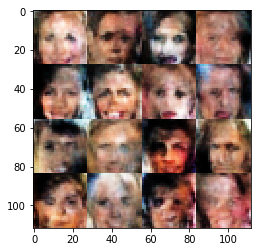

Epoch 6110/0... Discriminator Loss: 1.3017... Generator Loss: 0.9087
Epoch 6120/0... Discriminator Loss: 1.2236... Generator Loss: 1.0142
Epoch 6130/0... Discriminator Loss: 1.3068... Generator Loss: 0.7568
Epoch 6140/0... Discriminator Loss: 1.1638... Generator Loss: 0.6843
Epoch 6150/0... Discriminator Loss: 1.2260... Generator Loss: 1.2249
Epoch 6160/0... Discriminator Loss: 1.3298... Generator Loss: 1.2830
Epoch 6170/0... Discriminator Loss: 1.2999... Generator Loss: 0.8720
Epoch 6180/0... Discriminator Loss: 1.2397... Generator Loss: 1.1643
Epoch 6190/0... Discriminator Loss: 1.3286... Generator Loss: 1.0953
Epoch 6200/0... Discriminator Loss: 1.2094... Generator Loss: 0.8245


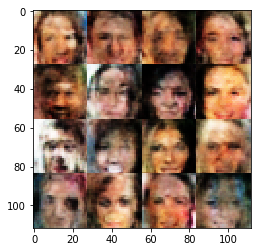

Epoch 6210/0... Discriminator Loss: 1.3083... Generator Loss: 0.7815
Epoch 6220/0... Discriminator Loss: 1.5383... Generator Loss: 0.4130
Epoch 6230/0... Discriminator Loss: 1.1388... Generator Loss: 0.9029
Epoch 6240/0... Discriminator Loss: 1.2118... Generator Loss: 0.8949
Epoch 6250/0... Discriminator Loss: 1.2078... Generator Loss: 1.0903
Epoch 6260/0... Discriminator Loss: 1.2809... Generator Loss: 0.6741
Epoch 6270/0... Discriminator Loss: 1.2243... Generator Loss: 0.7841
Epoch 6280/0... Discriminator Loss: 1.2584... Generator Loss: 0.8952
Epoch 6290/0... Discriminator Loss: 1.2347... Generator Loss: 1.2027
Epoch 6300/0... Discriminator Loss: 1.3136... Generator Loss: 0.8968


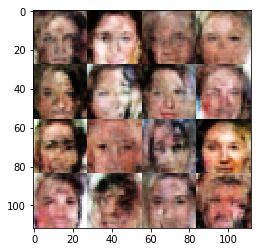

Epoch 6310/0... Discriminator Loss: 1.2208... Generator Loss: 0.7400
Epoch 6320/0... Discriminator Loss: 1.2309... Generator Loss: 0.8964
Epoch 6330/0... Discriminator Loss: 1.4188... Generator Loss: 1.4660
Epoch 6340/0... Discriminator Loss: 1.0730... Generator Loss: 1.1887
Epoch 6350/0... Discriminator Loss: 1.2999... Generator Loss: 0.9397
Epoch 6360/0... Discriminator Loss: 1.2824... Generator Loss: 0.7708
Epoch 6370/0... Discriminator Loss: 1.3563... Generator Loss: 0.6213
Epoch 6380/0... Discriminator Loss: 1.2580... Generator Loss: 0.7933
Epoch 6390/0... Discriminator Loss: 1.3811... Generator Loss: 0.7226
Epoch 6400/0... Discriminator Loss: 1.3849... Generator Loss: 0.8315


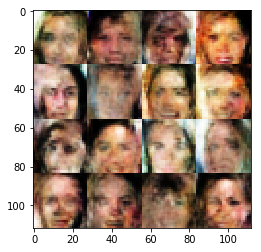

Epoch 6410/0... Discriminator Loss: 1.3525... Generator Loss: 1.1769
Epoch 6420/0... Discriminator Loss: 1.2742... Generator Loss: 1.0213
Epoch 6430/0... Discriminator Loss: 1.0871... Generator Loss: 1.3069
Epoch 6440/0... Discriminator Loss: 1.2848... Generator Loss: 0.6720
Epoch 6450/0... Discriminator Loss: 1.2290... Generator Loss: 0.7094
Epoch 6460/0... Discriminator Loss: 1.1436... Generator Loss: 1.1741
Epoch 6470/0... Discriminator Loss: 1.3582... Generator Loss: 1.0303
Epoch 6480/0... Discriminator Loss: 1.3299... Generator Loss: 0.9162
Epoch 6490/0... Discriminator Loss: 1.1686... Generator Loss: 1.1608
Epoch 6500/0... Discriminator Loss: 1.2626... Generator Loss: 1.2616


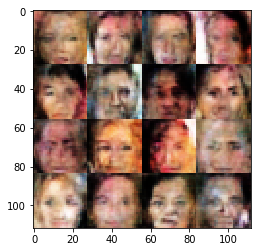

Epoch 6510/0... Discriminator Loss: 1.2347... Generator Loss: 1.1501
Epoch 6520/0... Discriminator Loss: 1.1086... Generator Loss: 1.1177
Epoch 6530/0... Discriminator Loss: 1.1506... Generator Loss: 0.8307
Epoch 6540/0... Discriminator Loss: 1.0774... Generator Loss: 0.9813
Epoch 6550/0... Discriminator Loss: 1.0966... Generator Loss: 1.0391
Epoch 6560/0... Discriminator Loss: 1.2973... Generator Loss: 1.0508
Epoch 6570/0... Discriminator Loss: 1.3294... Generator Loss: 0.8955
Epoch 6580/0... Discriminator Loss: 1.3771... Generator Loss: 1.5209
Epoch 6590/0... Discriminator Loss: 1.3736... Generator Loss: 0.6874
Epoch 6600/0... Discriminator Loss: 1.1642... Generator Loss: 0.8807


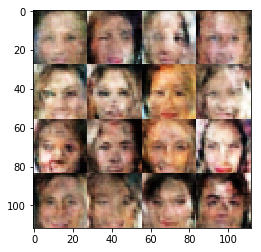

Epoch 6610/0... Discriminator Loss: 1.2272... Generator Loss: 0.8063
Epoch 6620/0... Discriminator Loss: 1.5722... Generator Loss: 1.2440
Epoch 6630/0... Discriminator Loss: 1.0984... Generator Loss: 0.9562
Epoch 6640/0... Discriminator Loss: 1.2246... Generator Loss: 1.0049
Epoch 6650/0... Discriminator Loss: 1.3335... Generator Loss: 0.8154
Epoch 6660/0... Discriminator Loss: 1.3829... Generator Loss: 1.2944
Epoch 6670/0... Discriminator Loss: 1.1892... Generator Loss: 0.9868
Epoch 6680/0... Discriminator Loss: 1.0885... Generator Loss: 1.0953
Epoch 6690/0... Discriminator Loss: 1.1541... Generator Loss: 1.0345
Epoch 6700/0... Discriminator Loss: 1.4258... Generator Loss: 0.7178


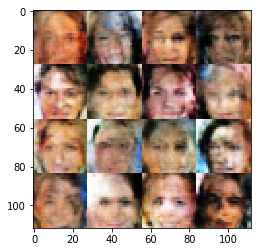

Epoch 6710/0... Discriminator Loss: 1.3635... Generator Loss: 0.6612
Epoch 6720/0... Discriminator Loss: 1.4290... Generator Loss: 1.3441
Epoch 6730/0... Discriminator Loss: 1.1175... Generator Loss: 1.0002
Epoch 6740/0... Discriminator Loss: 1.2595... Generator Loss: 0.7082
Epoch 6750/0... Discriminator Loss: 1.1625... Generator Loss: 0.9517
Epoch 6760/0... Discriminator Loss: 1.0835... Generator Loss: 1.0665
Epoch 6770/0... Discriminator Loss: 1.0777... Generator Loss: 1.1338
Epoch 6780/0... Discriminator Loss: 1.2550... Generator Loss: 0.9474
Epoch 6790/0... Discriminator Loss: 1.2988... Generator Loss: 1.0717
Epoch 6800/0... Discriminator Loss: 1.1179... Generator Loss: 0.9790


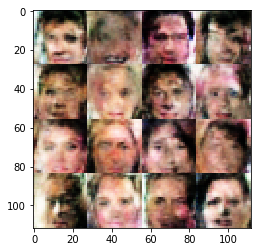

Epoch 6810/0... Discriminator Loss: 1.1534... Generator Loss: 1.0957
Epoch 6820/0... Discriminator Loss: 1.1843... Generator Loss: 0.8400
Epoch 6830/0... Discriminator Loss: 1.1876... Generator Loss: 0.6351
Epoch 6840/0... Discriminator Loss: 1.2759... Generator Loss: 0.9058
Epoch 6850/0... Discriminator Loss: 1.0150... Generator Loss: 1.1970
Epoch 6860/0... Discriminator Loss: 1.1589... Generator Loss: 1.1245
Epoch 6870/0... Discriminator Loss: 1.1159... Generator Loss: 1.1158
Epoch 6880/0... Discriminator Loss: 1.3558... Generator Loss: 1.2567
Epoch 6890/0... Discriminator Loss: 1.0413... Generator Loss: 1.2166
Epoch 6900/0... Discriminator Loss: 1.1266... Generator Loss: 1.3759


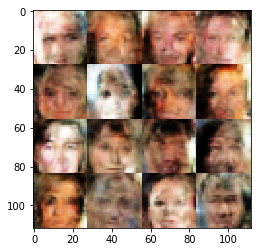

Epoch 6910/0... Discriminator Loss: 1.3417... Generator Loss: 0.9296
Epoch 6920/0... Discriminator Loss: 1.5134... Generator Loss: 0.6342
Epoch 6930/0... Discriminator Loss: 1.6172... Generator Loss: 1.3088
Epoch 6940/0... Discriminator Loss: 1.2476... Generator Loss: 0.9789
Epoch 6950/0... Discriminator Loss: 1.1897... Generator Loss: 1.2985
Epoch 6960/0... Discriminator Loss: 1.1306... Generator Loss: 0.9012
Epoch 6970/0... Discriminator Loss: 1.2018... Generator Loss: 1.0783
Epoch 6980/0... Discriminator Loss: 1.2796... Generator Loss: 1.2594
Epoch 6990/0... Discriminator Loss: 1.3713... Generator Loss: 1.0190
Epoch 7000/0... Discriminator Loss: 1.3480... Generator Loss: 0.8107


In [ ]:
batch_size = 16#None
z_dim =128 #None
learning_rate =0.001 #None
beta1 =0.5 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.